---
title: "Comparing Parametric and Non-Parametric Monte-Carlo and Machine Learning Approaches to Development of Risk-Adjusted Portfolio Construction"
format:
  pdf:
    toc: true
    toc-depth: 3
    geometry:
      - margin=15mm
---

## **Section 1: Introduction and Summary**

This notebook intends to analyze, compare, and provide insights on the performance of two fundamentally different approaches to **portfolio risk modelling and risk-adjusted portfolio construction**:

- One **machine-learning–based risk modelling framework**, and  
- Two **Monte Carlo simulation–based risk modelling frameworks - Parametric and Non-Parametric**.

The comparison is conducted across the following dimensions:

**1. Risk-adjusted performance comparison:**  
Measures how much excess return each approach generates - after accounting for its own risk profile. For this dimension, the 3 approaches will be compared using the following Out-of-Sample (OOS) parameters:

 - Rolling realized volatility (12Months)
 - Rolling model-implied volatility (under fixed weights $w^T$)
 - Regime-controlled Sharpe and Volatility
 - Regime-controlled Sharpe versus CVaR Trade-off

**2. Tail risk and drawdown analysis:**  
Measures the effectiveness of each portfolio construction approach in capturing and controlling extreme downside risk. For this dimension, the 3 approaches will be compared using the following OOS parameters:

 - Tail loss frequency
 - Expected shortfall duration
 - Maximum drawdown

**3. Portfolio stability analysis:**  
Measures the stability and consistency of portfolio decisions generated by each portfolio construction approach over time. For this dimension, the 3 approaches will be compared using the Monthly Turnover parameter.

Based on the findings above, this notebook aims to determine **Model Applicability**—that is, which framework is better suited for **risk estimation, portfolio optimization support, and stress-aware decision making**.


**1. Dataset Description**

The analysis uses **daily closing price data** spanning approximately **2001–2026**, covering multiple market regimes including the Global Financial Crisis (2008), the COVID-19 shock (2020), and the post-pandemic monetary tightening cycle.

The asset universe is intentionally restricted to three broad instruments to emphasize **diversification, correlation structure, and regime behavior**, rather than security-selection alpha:

1. **NIFTY 50 Index** – proxy for broad Indian equity market exposure (sourced from Zerodha using Kite API)
2. **NIFTY Bank Index** – proxy for cyclical, leverage-sensitive financial equities (sourced from Zerodha using Kite API)
3. **Gold** – proxy for defensive and inflation-hedging behavior (sourced from Yahoo Finance - COMEX Gold Futures - CMEGroup - GC=F)

Daily prices are transformed into **logarithmic returns**, which form the foundational input for all subsequent modelling stages. Log returns ensure time-additivity, scale consistency, and comparability across assets with heterogeneous price levels.


**2. Analytical Objective**

Unlike return-forecasting exercises, this notebook focuses explicitly on **risk estimation and portfolio behavior**. The primary objective of this exercise is **not** to attempt at predicting future prices or returns directly. Instead, this project evaluates how different risk-modelling philosophies interpret uncertainty and how that uncertainty affects portfolio outcomes.


**3. Modelling Approach**

Two distinct and complementary modelling frameworks are implemented.

*Monte Carlo Risk Modelling (Gaussian and Non-Gaussian)*

The Monte Carlo framework represents a **distribution-based, probabilistic approach** to risk estimation. Using historical return data, the model:

- Estimates expected returns and covariance structure  
- Simulates a large number of potential future return paths  
- Aggregates simulated outcomes to infer portfolio-level risk measures  

This approach explicitly models **distributional uncertainty** and is particularly well-suited for understanding tail risk and scenario dispersion.

*Machine Learning Risk Modelling*

The machine learning framework treats **risk as a conditional, learnable function of historical return dynamics**. Rather than assuming a fixed parametric distribution, the model infers patterns such as:

- Volatility clustering  
- Non-linear dependencies  
- Regime-dependent behavior  

Engineered features encode memory, dispersion, and drawdown effects observed in financial time series. Model outputs are used to generate **forward-looking volatility estimates**, which feed directly into portfolio construction.


**4. Portfolio Construction and Evaluation**

Portfolio construction is governed by a **single, fixed decision rule** applied consistently across both modelling approaches.

- **Risk-adjusted return metric:** Sharpe ratio  
- **Optimization objective:** Maximize Sharpe ratio  
- **Constraints:**  
  - Long-only  
  - Fully invested  

By comparing **pre- and post-rebalancing portfolios under each risk model and portfolio construction rule**, the notebook highlights how **model choice alone can materially alter portfolio behavior—even when using the same underlying assets**. Evaluation focuses on the 8 OOS parameters defined above.


**5. Implementation Methodology**

The empirical analysis follows a structured, walk-forward research design - to ensure methodological rigor and avoid look-ahead bias.

*Step 1: Data Collection and Cleansing*

Three independent price series are sourced:

- NIFTY 50 prices
- NIFTY Bank prices 
- Gold price proxy (Future Rates instead of Spot Rates)

All datasets are:

- Cleaned for missing observations  
- Aligned to a common date range  
- Prepared to ensure consistency across assets

*Step 2: Computation of Daily Log Returns*

For each asset:

- Daily log returns are computed  
- This return series constitutes the **only shared input across all models**  

All downstream modelling—Monte Carlo and ML—is built exclusively on this return representation.

*Step 3: Statistical Tests*

For each asset independently, the following statistical tests are performed:

1. Test of Kurtosis - to measure tail thickness - if leptokurtic/ platykurtic: select Non-Gaussian Monte-Carlo Approach - No change to XGBoost implementation but engineered features to be modified accordingly.
2. Test of Skewness - to check assymetry in the distribution - if left/ right skewed: select Non-Gaussian Monte-Carlo Approach - No change to XGBoost implementation but engineered features to be modified accordingly.
3. Normality Rejection Tests (Jarque–Bera (moment-based) and Anderson-Darling (tail-sensitive)) - to conclusively reject Gaussian Monte-Carlo Approach.
4. Volatility Clustering - ACF and Ljung-Box on squared returns - to confirm presence of heteroskedacity and subsequently support development of features for XGBoost model.

*Step 4: Feature Engineering (Asset-Specific)*

For each asset independently, the following features are engineered:

- Rolling volatility estimates (20-day, 60-day)  
- Lagged return terms  
- Rolling mean returns  
- Drawdown-based measures  

These features are **used exclusively by the machine learning framework** and are not inputs to the Monte Carlo simulation.

*Step 5: Portfolio Decision Rule Definition*

Prior to any modelling, the portfolio construction rule is defined **once and fixed throughout the study**.

- **Objective:** Maximize Sharpe ratio  
- **Constraints:**  
  - Long-only (only positive positions held in assets - no short positions considered)
  - Fully invested (portfolio weight = 100%)

This ensures that differences in outcomes arise solely from **risk estimation**, not from changing optimization logic.

*Step 6: Walk-Forward Portfolio Construction*

This step constitutes the core of the project and is repeated at each monthly rebalancing date.

*Step 6A — Monte Carlo Risk Estimation*

At rebalancing date $T$:

- Use only historical returns available up to $T$ (e.g., trailing 3 years)  
- Estimate:
  - Mean returns  
  - Covariance matrix (volatility and correlations)  
- Run Monte Carlo simulations to generate future return paths  
- Compute risk inputs for portfolio optimization  
- Pass these inputs into the Sharpe optimizer  
- Obtain portfolio weights

*Step 6B — Machine Learning Risk Estimation*

At the same rebalancing date $T$:

- Train ML models (per asset) using only historical features  
- Predict next-period volatility for each asset  
- Combine predicted volatilities with rolling correlation estimates  
- Construct a forecasted covariance matrix  
- Pass these inputs into the same Sharpe optimizer  
- Obtain portfolio weights

*Step 7: Out-of-Sample Holding Period*

- Both portfolios are held for the subsequent month  
- Realized portfolio returns are recorded  

*Step 8: Iteration Through Time*

Steps 6 and 7 are repeated across the full sample period, generating:

- A Monte Carlo–based portfolio return series  
- A Machine Learning–based portfolio return series  

*Step 9: Comparative Evaluation*

The two portfolios are compared across the 8 OOS parameters to draw conclusions on each.

**Disclaimer**

This notebook is intended solely for **methodological comparison and analytical insight**. The portfolios constructed are illustrative and do not constitute investment advice. All modelling frameworks rely on historical information and implicitly assume that past statistical properties are informative of future risk. In practice, financial markets are subject to **structural breaks, policy interventions, and exogenous shocks** that may invalidate these assumptions. Accordingly, results should be interpreted as **indicative rather than definitive**, and any real-world deployment would require additional validation, stress testing, and governance controls. This summarized document focuses purely on presenting the OOS results and final conclusion from the analysis. For a detailed study, please refer to the published report: 

In [2]:
# Importing necessary packages, data and performing data prep

# Importing necessary packages
import os, cudf, cupy, time
from dotenv import load_dotenv
import matplotlib.pyplot as plt, matplotlib.dates as mdates, numpy as np, pandas as pd

# Initializing environments
load_dotenv()
xgb_weights = os.getenv('xgb_weights')
xgb_monthly_portfolio_realized_returns = os.getenv('xgb_monthly_portfolio_realized_returns')
xgb_cov_matrix_pkl = os.getenv('xgb_cov_matrix_pkl')
mc_weights = os.getenv('mc_weights')
mc_monthly_portfolio_realized_returns = os.getenv('mc_monthly_portfolio_realized_returns')
mc_cov_matrix_pkl = os.getenv('mc_cov_matrix_pkl')

# Importing necessary data
xgb_weights_final_df = pd.read_csv(xgb_weights)
xgb_returns_final_df = pd.read_csv(xgb_monthly_portfolio_realized_returns)
mc_weights_final_df = pd.read_csv(mc_weights)
mc_returns_final_df = pd.read_csv(mc_monthly_portfolio_realized_returns)
mc_cov_matrix_final_df = pd.read_pickle(mc_cov_matrix_pkl)
xgb_cov_matrix_final_df = pd.read_pickle(xgb_cov_matrix_pkl)

# Data set tuning
xgb_weights_final_df['next_rebalance_date'] = pd.to_datetime(xgb_weights_final_df['next_rebalance_date']).dt.strftime('%Y-%m-%d')
xgb_returns_final_df['next_rebalance_date'] = pd.to_datetime(xgb_returns_final_df['next_rebalance_date']).dt.strftime('%Y-%m-%d')
mc_weights_final_df['next_rebalance_date'] = pd.to_datetime(mc_weights_final_df['next_rebalance_date']).dt.strftime('%Y-%m-%d')
mc_returns_final_df['next_rebalance_date'] = pd.to_datetime(mc_returns_final_df['next_rebalance_date']).dt.strftime('%Y-%m-%d')

xgb_weights_final_df = xgb_weights_final_df.set_index('next_rebalance_date')
xgb_returns_final_df = xgb_returns_final_df.set_index('next_rebalance_date')
mc_weights_final_df = mc_weights_final_df.set_index('next_rebalance_date')
mc_returns_final_df = mc_returns_final_df.set_index('next_rebalance_date')

# Generating master data file
master_returns_df = pd.merge(mc_returns_final_df, xgb_returns_final_df, how='inner', on='next_rebalance_date')
master_weights_df = pd.merge(mc_weights_final_df, xgb_weights_final_df, how='inner', on='next_rebalance_date')

## **Section 2: Out-of-Sample Performance Evaluation**

This section focuses on evaluating the Monte-Carlo and XGBoost models on the following out-of-sample (OOS) parameters:

1. Rolling realized volatility (12Months)
2. Rolling model-implied volatility (under fixed weights $w^T$)
3. Regime-controlled Sharpe and Volatility
4. Regime-controlled Sharpe versus CVaR Trade-off
5. Tail Loss Frequency
6. Expected Shortfall Duration
7. Maximum Drawdown
8. Monthly Turnover

While standard OOS predictive accuracy metrics such as RMSE, MAE, and R-squared have been computed for the XGBoost models, these metrics are **not used for out-of-sample portfolio performance evaluation**. This is because the objective of this study is to assess the effectiveness of conditional risk estimation, specifically second-moment processes such as volatility and correlation, rather than the accuracy of point forecasts of returns (a first-moment process). Since metrics such as RMSE and MAE are designed to evaluate point-estimate forecasts, their use in evaluating portfolio outcomes driven by risk forecasts would not be methodologically aligned with the objectives of this study.

To recap, our modelling approach followed the below methodology:

1. **Statistical evaluation of the underlying log returns** - to determine applicability of gaussian models as well as guide feature enginieering (for Monte-Carlo and XGBoost approaches respectively).
2. **Portfolio construction rule design (Maximize Sharpe)** - to standardize the portfolio construction mechanism across all approaches - for an apple-to-apple comparison.
3. **Setup of Gaussian and Non-Gaussian (Bootstrap) Monte-Carlo** - while all our statistical tests empirically established Non-Gaussian Monte-Carlo as the choice of approach, Gaussian Monte-Carlo was also included - purely for this study. To credibly establish the need for upfront statistical tests - and conforming to the same during real-world applications.
4. **Setup of XGBoost** - to define the dependent and independent datasets for model training.
5. **Setup of walkforward backtest** - to define (and standardize) the walkforward backtest mechanism - across all 3 approaches - to enforce an apple-to-apple comparison (1 month walkforward - holding the weights constant - and 3 years backtest)

This section evaluates the three portfolio construction approaches across complementary dimensions of risk-adjusted outcomes, tail-risk realism, and portfolio stability:

1. **Risk-adjusted performance comparison:** This sub-section will leverage OOS parameters 1-4 above, to provide insights on what level of return efficiency remains - given each model's risk controls.
2. **Tail risk and drawdown analysis:** This sub-section will leverage OOS parameters 5-7 above, to provide insights on which approach captures risk better (across all 3).
3. **Portfolio stability:** This sub-section will leverage OOS parameter 8 above, to provide insights on which approach results in a more stable - risk resilient - portfolio.

### 1. Risk-adjusted Performance Comparison (Gaussian Monte-Carlo v/s Bootstrap Monte-Carlo v/s XGBoost)

This sub-section evaluates the residual risk-adjusted performance of all three portfolio construction approaches, conditional on prevailing market regimes. The objective is not to identify the approach that maximizes returns, but to assess the level of return efficiency that remains after each model’s risk estimation and control mechanisms have been applied.

The following out-of-sample metrics are employed:

1. Rolling realized volatility (12-month window)
2. Rolling model-implied volatility (under fixed weights $w$)
3. Regime-controlled Sharpe and Volatility
4. Regime-controlled Sharpe versus CVaR Trade-off

Metrics 1 and 2 focus on differences in risk recognition and risk pricing behavior across approaches and metrics 3 and 4 identify how this translates to Sharpe. Since our study objective is "risk-adjusted portfolio construction" we want the ideal approach to be one that exhibits timely and regime-consistent risk sensitivity, rather than unconditional risk minimization - which metrics 1 and 2 will shed light on - and translate the risk awareness into stable excess returns - which will answer the question: Had an investor invested $100 in the portfolio, what kind of excess returns would they have received - given each approach's risk identification profile? In a real world scenario - this model would then ideally be used to benchmark multiple portfolios.

Sharpe ratios, and volatility, are evaluated conditionally across calm and stress regimes to avoid masking regime-specific risk–return trade-offs, thereby enabling a more nuanced assessment of how each approach balances return efficiency against downside risk within its respective risk estimation framework.

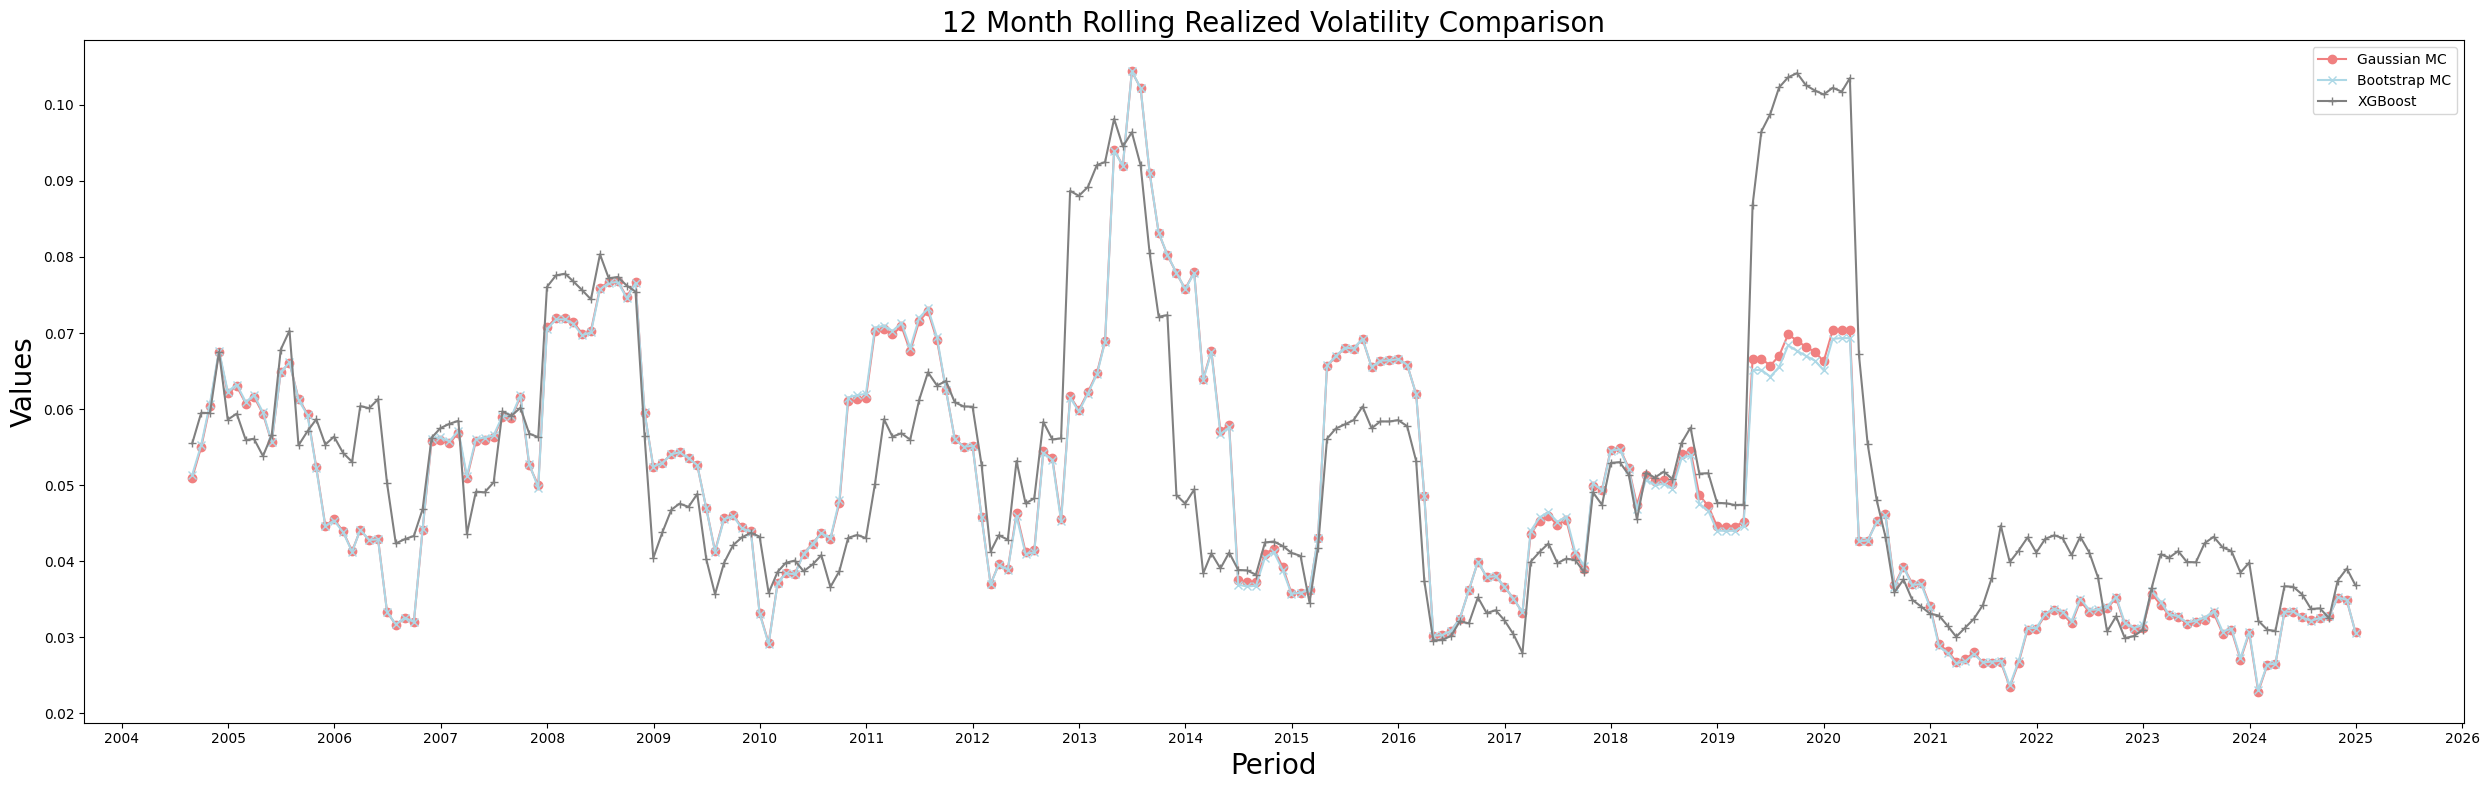

In [3]:
# Rolling realized volatility (12-month window)
rol_rel_vol = master_returns_df.copy()

# Step 1: Generating rolling 12 Month volatilities - based on simple returns
rol_rel_vol['boot_mc_rol_vol_12M'] = rol_rel_vol['monthly_simple_returns_boot_mc'].rolling(12).std(ddof=1)
rol_rel_vol['gauss_mc_rol_vol_12M'] = rol_rel_vol['monthly_simple_returns_gauss_mc'].rolling(12).std(ddof=1)
rol_rel_vol['xgb_rol_vol_12M'] = rol_rel_vol['monthly_simple_returns_xgb'].rolling(12).std(ddof=1)
rol_rel_vol = rol_rel_vol.dropna(how='any')

# Step 2: Generating datasets for plot
x_data = pd.to_datetime(rol_rel_vol.index).to_list()
y_data_gauss_mc = rol_rel_vol['gauss_mc_rol_vol_12M'].to_list()
y_data_boot_mc = rol_rel_vol['boot_mc_rol_vol_12M'].to_list()
y_data_xgb = rol_rel_vol['xgb_rol_vol_12M'].to_list()

# Generating plot
fig_rol_vol, ax_rol_vol = plt.subplots(figsize=(25, 8), dpi=100)
plt.plot(x_data, y_data_gauss_mc, color='lightcoral', marker='o', label='Gaussian MC')
plt.plot(x_data, y_data_boot_mc, color='lightblue', marker='x', label='Bootstrap MC')
plt.plot(x_data, y_data_xgb, color='grey', marker='+', label='XGBoost')
ax_rol_vol.set_title('12 Month Rolling Realized Volatility Comparison', fontsize=20)
ax_rol_vol.set_xlabel('Period', fontsize=20)
ax_rol_vol.set_ylabel('Values', fontsize=20)
ax_rol_vol.xaxis.set_major_locator(mdates.MonthLocator([12]))
ax_rol_vol.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_rol_vol.legend()
plt.tight_layout()
plt.show()

**Analysis Conclusion - Rolling Realized Volatility**

The rolling 12-month realized volatility profiles of the Gaussian and Bootstrap Monte-Carlo approaches exhibit closely aligned and relatively smooth dynamics across the sample, reflecting gradual risk absorption and mean-reverting behavior. Bootstrap Monte-Carlo displays marginally higher realized volatility during stress periods, consistent with its ability to incorporate empirical distributional features beyond the Gaussian assumption. However, the overall similarity in volatility trajectories indicates that both Monte-Carlo frameworks primarily smooth risk over time, normalizing portfolio variability as shocks are absorbed into the rolling window.

In contrast, the XGBoost-based approach exhibits sharper transitions and greater persistence in realized volatility once higher-risk regimes are identified. This behavior reflects the model’s regime-conditional design, whereby portfolio allocations adjust discretely in response to changes in volatility and correlation states rather than continuously. As a result, XGBoost maintains elevated realized volatility for longer durations during and following stress events, avoiding rapid re-risking during transitional market phases. Importantly, this volatility profile does not indicate excessive risk-taking, but rather a structurally more conservative response that prioritizes sustained risk awareness over volatility compression, reinforcing the model’s suitability for robust risk identification and capture.

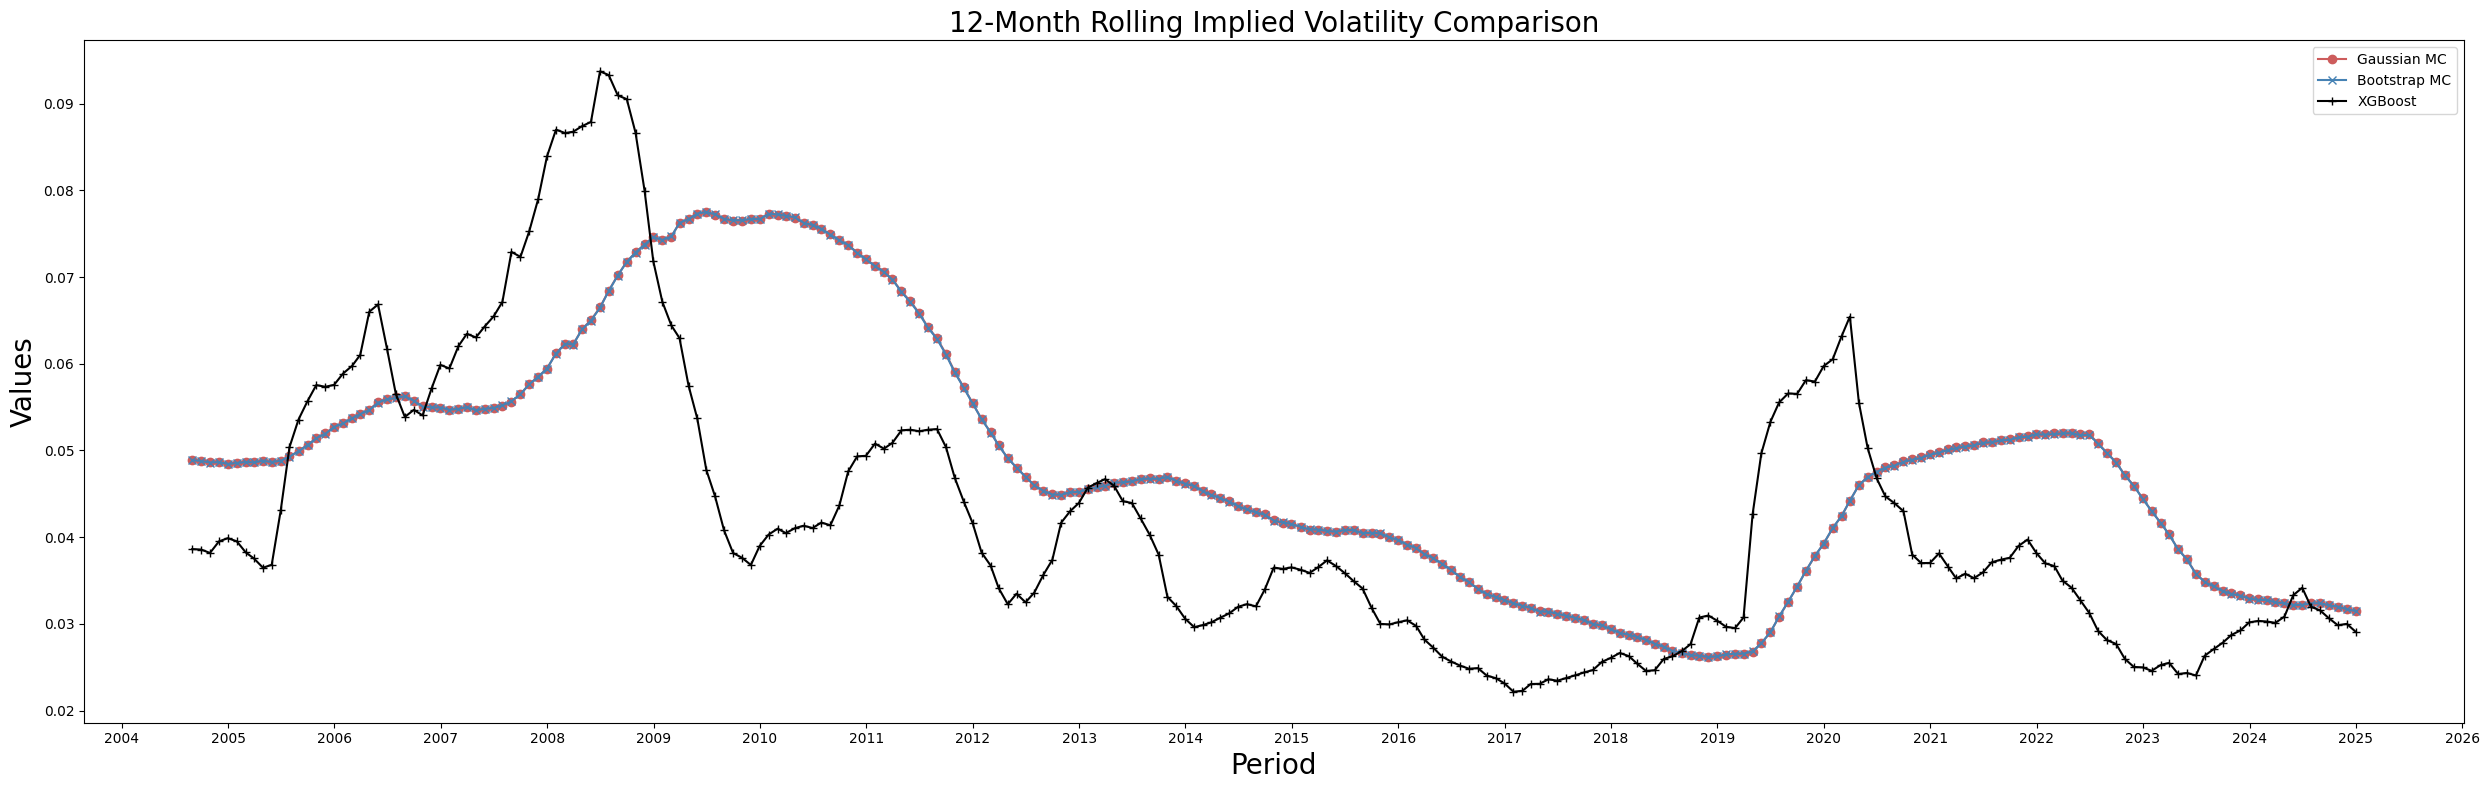

In [4]:
# Rolling model implied volatility (under fixed weights)
master_cov_data = mc_cov_matrix_final_df.join(xgb_cov_matrix_final_df, how='inner')

# Step 1: Generating fixed weights - to remove impact of model weights
n_assets = 3
w = np.ones(n_assets)/n_assets
w = w.reshape(-1, 1)
gauss_vol_list = []
boot_vol_list = []
xgb_vol_list = []

# Step 2: Generating model volatility - Gaussian MC
cov_gauss = master_cov_data['cov_matrix_gauss_mc']
for i in range(len(cov_gauss)):
    gauss_vol = np.sqrt(np.transpose(w) @ cov_gauss.iloc[i] @ w).item()
    gauss_vol_list.append(gauss_vol)

# Step 3: Generating model volatility - Bootstrap MC
cov_boot = master_cov_data['cov_matrix_boot_mc']
for i in range(len(cov_boot)):
    boot_vol = np.sqrt(np.transpose(w) @ cov_boot.iloc[i] @ w).item()
    boot_vol_list.append(boot_vol)

# Step 4: Generating model volatility - XGB
cov_xgb = master_cov_data['cov_matrix_xgb']
for i in range(len(cov_xgb)):
    xgb_vol = np.sqrt(np.transpose(w) @ cov_xgb.iloc[i] @ w).item()
    xgb_vol_list.append(xgb_vol)

# Step 5: Updating dataset with calculated volatilities
master_cov_data['mc_gauss_vol'] = gauss_vol_list
master_cov_data['mc_boot_vol'] = boot_vol_list
master_cov_data['xgb_vol'] = xgb_vol_list

# Step 6: Calculating rolling 12-month volatilities
master_cov_data['rol_vol_gauss_12M'] = master_cov_data['mc_gauss_vol'].rolling(12).mean()
master_cov_data['rol_vol_boot_12M'] = master_cov_data['mc_boot_vol'].rolling(12).mean()
master_cov_data['rol_vol_xgb_12M'] = master_cov_data['xgb_vol'].rolling(12).mean()
master_cov_data = master_cov_data.dropna(how='any')

# Step 7: Synthesizing data for plots
x_data_rol_vol = pd.to_datetime(master_cov_data.index).to_list()
y_rol_vol_gauss = master_cov_data['rol_vol_gauss_12M'].to_list()
y_rol_vol_boot = master_cov_data['rol_vol_boot_12M'].to_list()
y_rol_vol_xgb = master_cov_data['rol_vol_xgb_12M'].to_list()

# Step 8: Generating plots
fig_rol_imp_vol, ax_rol_imp_vol = plt.subplots(figsize=(25, 8), dpi=100)
plt.plot(x_data_rol_vol, y_rol_vol_gauss, color='indianred', marker='o', label='Gaussian MC')
plt.plot(x_data_rol_vol, y_rol_vol_boot, color='steelblue', marker='x', label='Bootstrap MC')
plt.plot(x_data_rol_vol, y_rol_vol_xgb, color='black', marker='+', label='XGBoost')
ax_rol_imp_vol.set_title('12-Month Rolling Implied Volatility Comparison', fontsize=20)
ax_rol_imp_vol.set_xlabel('Period', fontsize=20)
ax_rol_imp_vol.set_ylabel('Values', fontsize=20)
ax_rol_imp_vol.legend()
ax_rol_imp_vol.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_rol_imp_vol.xaxis.set_major_locator(mdates.MonthLocator([12]))
plt.tight_layout()
plt.show()

**Analysis Conclusion - Rolling Implied Volatility**

The implied- and realized-volatility profiles show that all three approaches respond to major stress regimes, with the XGBoost-based framework exhibiting sharper and higher-amplitude risk responses around the 2008–09 financial crisis and the 2019–20 COVID episode. Under fixed equal weights, XGBoost produces more abrupt increases in model-implied volatility, consistent with stronger regime sensitivity embedded in its volatility and correlation estimates. In contrast, both Monte-Carlo approaches display smoother and more persistent volatility plateaus, indicative of slower risk normalization and stronger averaging effects inherent in distribution-based covariance estimation.

Importantly, differences in spike magnitude should be interpreted as differences in implied risk assigned to the same equal-weight portfolio, rather than as definitive evidence of superior or inferior estimation of “true” risk. Realized volatility can converge across approaches even when implied volatility diverges, as realized outcomes reflect each model’s endogenous allocation choices and the trailing-window construction used in realized-risk measurement.

Overall, the results indicate that XGBoost reacts more discontinuously to regime shifts, while Monte-Carlo models adjust risk more gradually, consistent with their respective modelling assumptions. The discontinuous response observed under XGBoost reflects a more decisive regime classification mechanism, whereas Monte-Carlo approaches produce smoother, continuously adjusted risk estimates driven by distributional averaging.

Number of calm months (out of total evaluation of 21 years): 110
Number of stress months (out of total evaluation of 21 years): 111


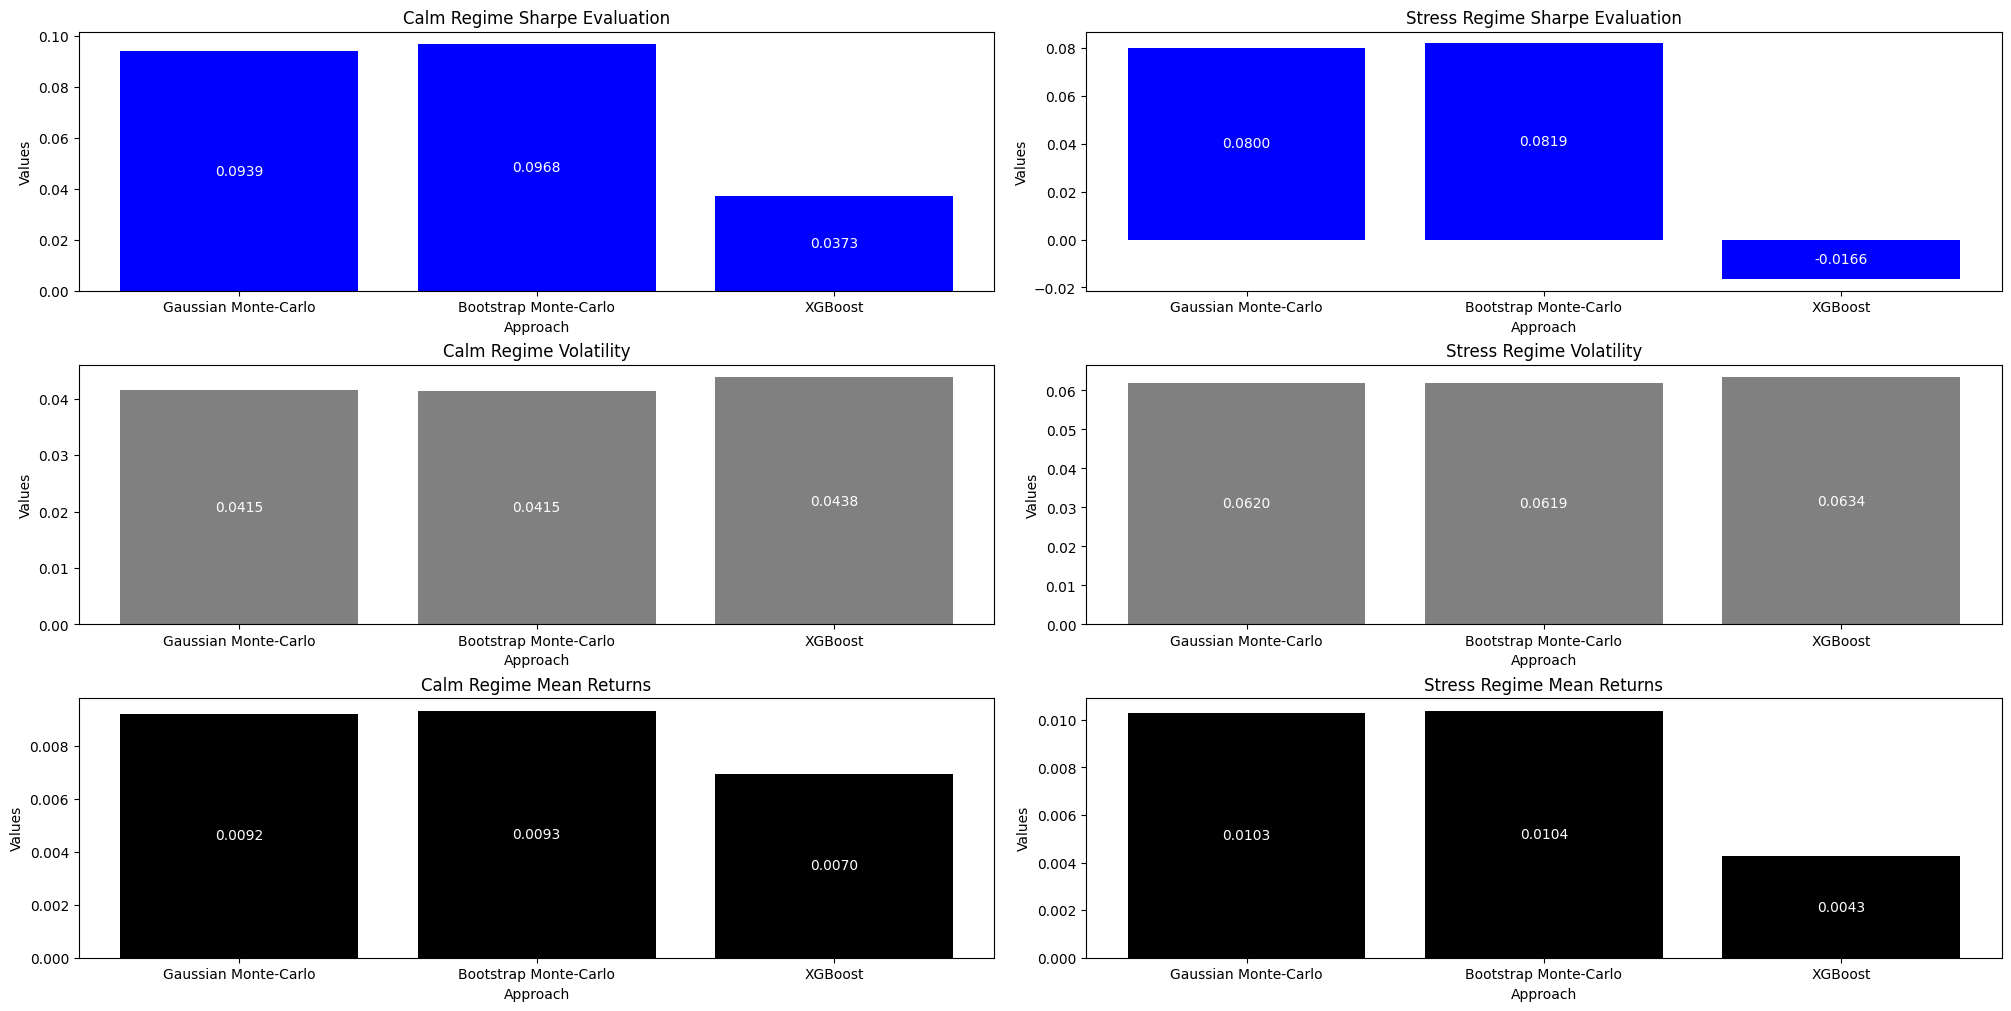

In [11]:
# Regime-controlled sharpe and volatility
risk_free_rate = ((1 + 0.065726) ** (1/12)) - 1 # 10-year govt. yeild - Source: TE - Converted to monthly

# Step 1: Generate copy of master data for implementation
regime_df = master_returns_df.copy()

# Step 2: Constructing a neutral proxy return
regime_df['neutral_proxy_return'] = (
    regime_df['monthly_simple_returns_boot_mc']
    + regime_df['monthly_simple_returns_gauss_mc']
    + regime_df['monthly_simple_returns_xgb']
) / 3

# Step 3: Calculating rolling 36 Month volatility of neutral returns
regime_df['rolling_vol_proxy_36'] = (
    regime_df['neutral_proxy_return']
    .rolling(36)
    .std(ddof=1)
)
regime_df = regime_df.dropna(subset='rolling_vol_proxy_36', how='any')

# Step 4: Generating regime identification - 2 subclassifications - CALM and STRESS
roll_vol_median = regime_df['rolling_vol_proxy_36'].median()
regime_df['regime_classification'] = (
    regime_df['rolling_vol_proxy_36'] < roll_vol_median
).astype(int) # 1: Calm, 0: Stress
calm_period = (
    regime_df['regime_classification'] == 1
).sum()
stress_period = (
    regime_df['regime_classification'] == 0
).sum()
print(f'Number of calm months (out of total evaluation of 21 years): {int(calm_period)}')
print(f'Number of stress months (out of total evaluation of 21 years): {int(stress_period)}')

# Step 5: Computing sharpe for calm regime
mean_returns_calm_gauss_mc = regime_df.loc[
    regime_df['regime_classification'] == 1,
    'monthly_simple_returns_gauss_mc'
].mean()
vol_returns_calm_gauss_mc = regime_df.loc[
    regime_df['regime_classification'] == 1,
    'monthly_simple_returns_gauss_mc'
].std(ddof=1)
mean_returns_calm_boot_mc = regime_df.loc[
    regime_df['regime_classification'] == 1,
    'monthly_simple_returns_boot_mc'
].mean()
vol_returns_calm_boot_mc = regime_df.loc[
    regime_df['regime_classification'] == 1,
    'monthly_simple_returns_boot_mc'
].std(ddof=1)
mean_returns_calm_xgb = regime_df.loc[
    regime_df['regime_classification'] == 1,
    'monthly_simple_returns_xgb'
].mean()
vol_returns_calm_xgb = regime_df.loc[
    regime_df['regime_classification'] == 1,
    'monthly_simple_returns_xgb'
].std(ddof=1)
sharpe_calm_gauss_mc = (mean_returns_calm_gauss_mc - risk_free_rate) / vol_returns_calm_gauss_mc
sharpe_calm_boot_mc = (mean_returns_calm_boot_mc - risk_free_rate) / vol_returns_calm_boot_mc
sharpe_calm_xgb = (mean_returns_calm_xgb - risk_free_rate) / vol_returns_calm_xgb

# Step 6: Computing sharpe for stress regime
mean_returns_stress_gauss_mc = regime_df.loc[
    regime_df['regime_classification'] == 0,
    'monthly_simple_returns_gauss_mc'
].mean()
vol_returns_stress_gauss_mc = regime_df.loc[
    regime_df['regime_classification'] == 0,
    'monthly_simple_returns_gauss_mc'
].std(ddof=1)
mean_returns_stress_boot_mc = regime_df.loc[
    regime_df['regime_classification'] == 0,
    'monthly_simple_returns_boot_mc'
].mean()
vol_returns_stress_boot_mc = regime_df.loc[
    regime_df['regime_classification'] == 0,
    'monthly_simple_returns_boot_mc'
].std(ddof=1)
mean_returns_stress_xgb = regime_df.loc[
    regime_df['regime_classification'] == 0,
    'monthly_simple_returns_xgb'
].mean()
vol_returns_stress_xgb = regime_df.loc[
    regime_df['regime_classification'] == 0,
    'monthly_simple_returns_xgb'
].std(ddof=1)
sharpe_stress_gauss_mc = (mean_returns_stress_gauss_mc - risk_free_rate) / vol_returns_stress_gauss_mc
sharpe_stress_boot_mc = (mean_returns_stress_boot_mc - risk_free_rate) / vol_returns_stress_boot_mc
sharpe_stress_xgb = (mean_returns_stress_xgb - risk_free_rate) / vol_returns_stress_xgb

# Step 7: Plotting the comparison graphs
x_data = ['Gaussian Monte-Carlo', 'Bootstrap Monte-Carlo', 'XGBoost']
y_data_c = [sharpe_calm_gauss_mc, sharpe_calm_boot_mc, sharpe_calm_xgb]
y_data_s = [sharpe_stress_gauss_mc, sharpe_stress_boot_mc, sharpe_stress_xgb]
y_data_cv = [vol_returns_calm_gauss_mc, vol_returns_calm_boot_mc, vol_returns_calm_xgb]
y_data_sv = [vol_returns_stress_gauss_mc, vol_returns_stress_boot_mc, vol_returns_stress_xgb]
y_data_cr = [mean_returns_calm_gauss_mc, mean_returns_calm_boot_mc, mean_returns_calm_xgb]
y_data_sr = [mean_returns_stress_gauss_mc, mean_returns_stress_boot_mc, mean_returns_stress_xgb]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10), dpi=100, constrained_layout=True)
bars_c = axes[0,0].bar(x_data, y_data_c, color='blue')
axes[0,0].bar_label(bars_c, fmt='%.4f', label_type = 'center', color='white')
axes[0,0].set_title('Calm Regime Sharpe Evaluation')
axes[0,0].set_xlabel('Approach')
axes[0,0].set_ylabel('Values')
bars_s = axes[0,1].bar(x_data, y_data_s, color='blue')
axes[0,1].bar_label(bars_s, fmt='%.4f', label_type = 'center', color='white')
axes[0,1].set_title('Stress Regime Sharpe Evaluation')
axes[0,1].set_xlabel('Approach')
axes[0,1].set_ylabel('Values')
bars_cv = axes[1,0].bar(x_data, y_data_cv, color='grey')
axes[1,0].bar_label(bars_cv, fmt='%.4f', label_type = 'center', color='white')
axes[1,0].set_title('Calm Regime Volatility')
axes[1,0].set_xlabel('Approach')
axes[1,0].set_ylabel('Values')
bars_sv = axes[1,1].bar(x_data, y_data_sv, color='grey')
axes[1,1].bar_label(bars_sv, fmt='%.4f', label_type = 'center', color='white')
axes[1,1].set_title('Stress Regime Volatility')
axes[1,1].set_xlabel('Approach')
axes[1,1].set_ylabel('Values')
bars_cr = axes[2,0].bar(x_data, y_data_cr, color='black')
axes[2,0].bar_label(bars_cr, fmt='%.4f', label_type = 'center', color='white')
axes[2,0].set_title('Calm Regime Mean Returns')
axes[2,0].set_xlabel('Approach')
axes[2,0].set_ylabel('Values')
bars_sr = axes[2,1].bar(x_data, y_data_sr, color='black')
axes[2,1].bar_label(bars_sr, fmt='%.4f', label_type = 'center', color='white')
axes[2,1].set_title('Stress Regime Mean Returns')
axes[2,1].set_xlabel('Approach')
axes[2,1].set_ylabel('Values')
plt.show()

**Analysis Conclusion - Regime-Controlled Sharpe and Volatility**

The regime-controlled Sharpe and volatility analysis reinforces the structural differences observed in the implied- and realized-volatility assessments, highlighting how each modelling framework translates its risk perception into realized portfolio outcomes under distinct market conditions.

Across both calm and stress regimes, the Gaussian and Bootstrap Monte-Carlo approaches exhibit closely aligned Sharpe ratios and realized volatility levels, with Bootstrap Monte-Carlo delivering a marginal Sharpe advantage in both regimes. This modest improvement remains consistent with the Bootstrap framework’s ability to relax Gaussian distributional assumptions while still benefiting from the smoothing and averaging effects inherent in Monte-Carlo covariance estimation. Importantly, the similarity in regime-level volatility between the two Monte-Carlo variants indicates that their risk identification and normalization dynamics remain broadly comparable, even during stress periods.

In contrast, the XGBoost-based approach reports materially lower Sharpe ratios across both regimes, accompanied by slightly higher realized volatility, particularly in calm market conditions. When interpreted alongside the implied-volatility analysis, this outcome reflects a structural feature of the XGBoost framework rather than inferior execution. The model exhibits a more discontinuous and regime-sensitive risk perception, leading to conservative allocations that persist even when realized volatility appears subdued. As a result, XGBoost forgoes return re-expansion during calm regimes in favor of maintaining heightened risk awareness.

During stress regimes, realized volatility under XGBoost converges toward Monte-Carlo levels despite higher implied-risk signals, indicating that the model’s endogenous allocation adjustments partially offset elevated risk perceptions. This convergence underscores the distinction between ex-ante risk identification and ex-post realized outcomes: while XGBoost assigns higher implied risk to stress environments, its portfolio construction dampens realized volatility through defensive positioning, leading to Sharpe suppression without disproportionate volatility escalation.

Overall, the regime-controlled results are fully consistent with the broader volatility diagnostics. Monte-Carlo approaches—particularly Bootstrap Monte-Carlo—deliver smoother risk normalization and marginally superior Sharpe performance through continuous, distribution-driven adjustment. By contrast, the XGBoost framework demonstrates a more decisive and conservative regime classification, prioritizing robust risk identification and persistence over return maximization. The resulting Sharpe suppression should therefore be interpreted not as a weakness, but as evidence that XGBoost emphasizes regime awareness and downside protection, aligning with the study’s objective of risk-aware portfolio construction.

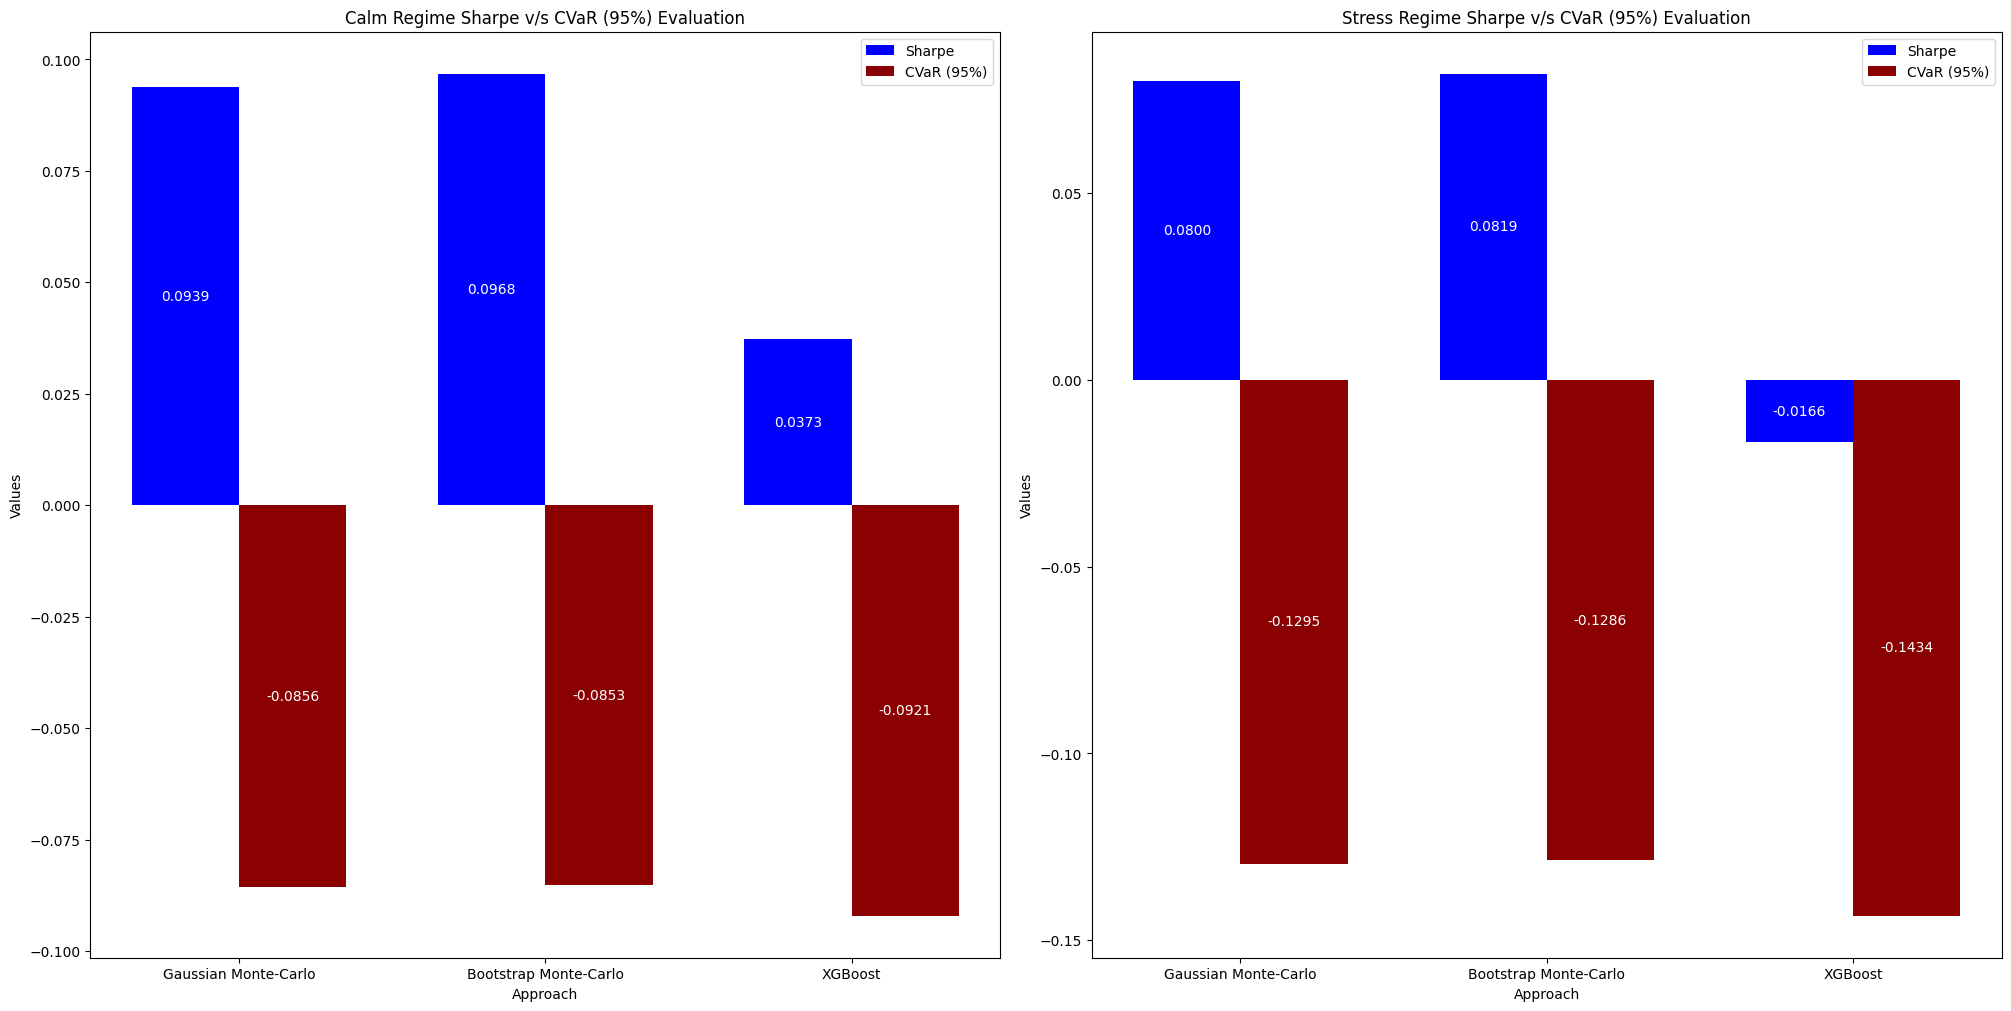

In [6]:
# Sharpe vs CVaR trade-off
# Step 1: Calculating CVaR for Stress Regime 
regime_df_stress_gauss_mc = regime_df.loc[
    regime_df['regime_classification'] == 0,
    'monthly_simple_returns_gauss_mc'
].sort_values(ascending=True)
regime_df_stress_gauss_mc_5Q = regime_df_stress_gauss_mc.quantile(0.05, interpolation='lower')
regime_df_stress_gauss_mc_cvar = regime_df_stress_gauss_mc[
    regime_df_stress_gauss_mc <= regime_df_stress_gauss_mc_5Q
].mean()
regime_df_stress_boot_mc = regime_df.loc[
    regime_df['regime_classification'] == 0,
    'monthly_simple_returns_boot_mc'
].sort_values(ascending=True)
regime_df_stress_boot_mc_5Q = regime_df_stress_boot_mc.quantile(0.05, interpolation='lower')
regime_df_stress_boot_mc_cvar = regime_df_stress_boot_mc[
    regime_df_stress_boot_mc <= regime_df_stress_boot_mc_5Q
].mean()
regime_df_stress_xgb = regime_df.loc[
    regime_df['regime_classification'] == 0,
    'monthly_simple_returns_xgb'
].sort_values(ascending=True)
regime_df_stress_xgb_5Q = regime_df_stress_xgb.quantile(0.05, interpolation='lower')
regime_df_stress_xgb_cvar = regime_df_stress_xgb[
    regime_df_stress_xgb <= regime_df_stress_xgb_5Q
].mean()

# Step 2: Calculating CVaR for Calm Regime 
regime_df_calm_gauss_mc = regime_df.loc[
    regime_df['regime_classification'] == 1,
    'monthly_simple_returns_gauss_mc'
].sort_values(ascending=True)
regime_df_calm_gauss_mc_5Q = regime_df_calm_gauss_mc.quantile(0.05, interpolation='lower')
regime_df_calm_gauss_mc_cvar = regime_df_calm_gauss_mc[
    regime_df_calm_gauss_mc <= regime_df_calm_gauss_mc_5Q
].mean()
regime_df_calm_boot_mc = regime_df.loc[
    regime_df['regime_classification'] == 1,
    'monthly_simple_returns_boot_mc'
].sort_values(ascending=True)
regime_df_calm_boot_mc_5Q = regime_df_calm_boot_mc.quantile(0.05, interpolation='lower')
regime_df_calm_boot_mc_cvar = regime_df_calm_boot_mc[
    regime_df_calm_boot_mc <= regime_df_calm_boot_mc_5Q
].mean()
regime_df_calm_xgb = regime_df.loc[
    regime_df['regime_classification'] == 1,
    'monthly_simple_returns_xgb'
].sort_values(ascending=True)
regime_df_calm_xgb_5Q = regime_df_calm_xgb.quantile(0.05, interpolation='lower')
regime_df_calm_xgb_cvar = regime_df_calm_xgb[
    regime_df_calm_xgb <= regime_df_calm_xgb_5Q
].mean()

# Step 3: Plotting the comparison charts
x = np.arange(len(x_data))
width = 0.35
y_data_ccvar = [regime_df_calm_gauss_mc_cvar, regime_df_calm_boot_mc_cvar, regime_df_calm_xgb_cvar]
y_data_scvar = [regime_df_stress_gauss_mc_cvar, regime_df_stress_boot_mc_cvar, regime_df_stress_xgb_cvar]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi=100, constrained_layout=True)
bars_c = axes[0].bar(x - width / 2, y_data_c, width, color='blue', label='Sharpe')
bars_ccvar = axes[0].bar(x + width / 2, y_data_ccvar, width, color='darkred', label='CVaR (95%)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(x_data)
axes[0].bar_label(bars_c, fmt='%.4f', label_type = 'center', color='white')
axes[0].bar_label(bars_ccvar, fmt='%.4f', label_type = 'center', color='white')
axes[0].legend()
axes[0].set_title('Calm Regime Sharpe v/s CVaR (95%) Evaluation')
axes[0].set_xlabel('Approach')
axes[0].set_ylabel('Values')
bars_s = axes[1].bar(x - width / 2, y_data_s, width, color='blue', label='Sharpe')
bars_scvar = axes[1].bar(x + width / 2, y_data_scvar, width, color='darkred', label='CVaR (95%)')
axes[1].bar_label(bars_s, fmt='%.4f', label_type = 'center', color='white')
axes[1].bar_label(bars_scvar, fmt='%.4f', label_type = 'center', color='white')
axes[1].set_xticks(x)
axes[1].set_xticklabels(x_data)
axes[1].legend()
axes[1].set_title('Stress Regime Sharpe v/s CVaR (95%) Evaluation')
axes[1].set_xlabel('Approach')
axes[1].set_ylabel('Values')
plt.show()

**Analysis Conclusion - Regime-Controlled Sharpe v/s CVaR**

The regime-wise Sharpe–CVaR comparison complements the implied and realized volatility diagnostics by explicitly characterizing how each modelling framework trades off return efficiency against tail-risk exposure under different market conditions. Together, these results clarify not only how much risk each approach realizes, but why that risk materializes given the model’s underlying risk perception and allocation behavior.

*Calm Regime:*
During low-stress market conditions, both Gaussian and Bootstrap Monte-Carlo approaches exhibit comparable and well-contained tail risk, with nearly identical CVaR magnitudes at the 95% confidence level. Bootstrap Monte-Carlo delivers a marginal Sharpe advantage over its Gaussian counterpart without a corresponding deterioration in CVaR, consistent with its modestly improved return extraction observed in the regime-controlled Sharpe and volatility analysis. This outcome aligns with the implied-volatility findings, where both Monte-Carlo models assign similar risk levels to calm regimes and normalize risk smoothly through distribution-driven averaging.

In contrast, XGBoost reports a materially lower Sharpe ratio alongside a more severe CVaR even in calm regimes. When interpreted jointly with the implied-volatility analysis, this reflects a conservative risk stance rather than poor execution. XGBoost assigns elevated implied risk to transitional and ostensibly calm periods and, as a result, maintains defensive positioning that suppresses upside participation. The higher calm-regime CVaR therefore arises not from excessive risk-taking, but from a reluctance to re-risk aggressively following prior stress, consistent with the model’s regime-persistent design.

*Stress Regime:*
Under stressed market conditions, differences across approaches become more pronounced. Both Monte-Carlo frameworks continue to generate positive Sharpe ratios while containing CVaR losses at levels materially smaller than those observed under XGBoost. Bootstrap Monte-Carlo again marginally outperforms the Gaussian specification on Sharpe without increasing tail exposure, reinforcing its relative robustness under adverse distributional shifts. These results are consistent with the realized-volatility analysis, where Monte-Carlo portfolios exhibit smoother volatility responses and faster normalization following stress shocks.

XGBoost, by contrast, records the deepest CVaR losses and a negative Sharpe ratio in stress regimes. Importantly, this outcome must be interpreted in conjunction with the implied-volatility findings: XGBoost assigns substantially higher ex-ante risk to stress environments and reacts more discontinuously to regime shifts. While realized volatility ultimately converges toward Monte-Carlo levels due to defensive reallocation, return suppression dominates, resulting in inferior Sharpe performance and more severe CVaR. This pattern reflects heightened sensitivity to tail events rather than an inability to manage realized volatility.

*Overall Interpretation:*
Taken together, the regime-controlled Sharpe–CVaR results reinforce a clear methodological distinction across approaches. Bootstrap Monte-Carlo offers the most balanced risk–return profile, consistently delivering marginal Sharpe improvements without exacerbating tail risk, while Gaussian Monte-Carlo provides stable and predictable outcomes through continuous risk averaging. XGBoost, in contrast, systematically prioritizes tail-risk identification and regime persistence over return efficiency, leading to lower Sharpe ratios and deeper CVaR losses across regimes. Importantly, these outcomes are fully consistent with the model’s implied- and realized-volatility behavior and should not be interpreted as underperformance. Rather, they reflect a design philosophy centered on decisive regime classification and conservative risk management, aligning closely with the study’s objective of evaluating risk-aware—rather than return-maximizing—portfolio construction frameworks.

### 2. Tail Risk and Drawdown Analysis (Gaussian Monte-Carlo v/s Bootstrap Monte-Carlo v/s XGBoost)

This sub-section evaluates the effectiveness of each portfolio construction approach in capturing and controlling extreme downside risk. Unlike the preceding risk-adjusted performance analysis, which focuses on residual return efficiency after risk controls, the emphasis here is explicitly on loss severity, tail exposure, and capital drawdowns under adverse market conditions.

The objective is to assess how well each modelling framework identifies and mitigates persistent and recurring extreme outcomes, rather than how efficiently it converts risk into returns.

The following out-of-sample metrics are employed:
1. Tail Loss Frequency – to measure how often realized portfolio returns breach a predefined downside threshold (e.g., the empirical 5th percentile), capturing the recurrence of extreme negative events
2. Expected Shortfall Duration – to evaluate the average length of consecutive periods spent in the loss tail once a tail event is triggered, reflecting the persistence of downside stress
3. Maximum Drawdown – to quantify peak-to-trough capital erosion over the full evaluation horizon

Tail Loss Frequency captures the incidence of extreme losses, providing insight into how frequently each modelling approach exposes the portfolio to tail-risk realizations. Expected Shortfall Duration complements this by measuring the temporal clustering of tail events, highlighting whether losses are isolated shocks or part of sustained adverse regimes. Together, these metrics provide a more complete characterization of downside risk than single-period loss magnitude alone.

Maximum drawdown is included as a path-dependent measure of capital preservation, capturing the cumulative impact of prolonged or repeated tail-risk realizations on investor wealth.

All tail-risk measures are computed using historical (empirical) distributions to avoid imposing parametric assumptions that may understate non-normality, skewness, or fat-tailed behavior in realized portfolio returns. Maximum drawdown is evaluated over the complete out-of-sample period to reflect real-world investor experience under sustained market stress.

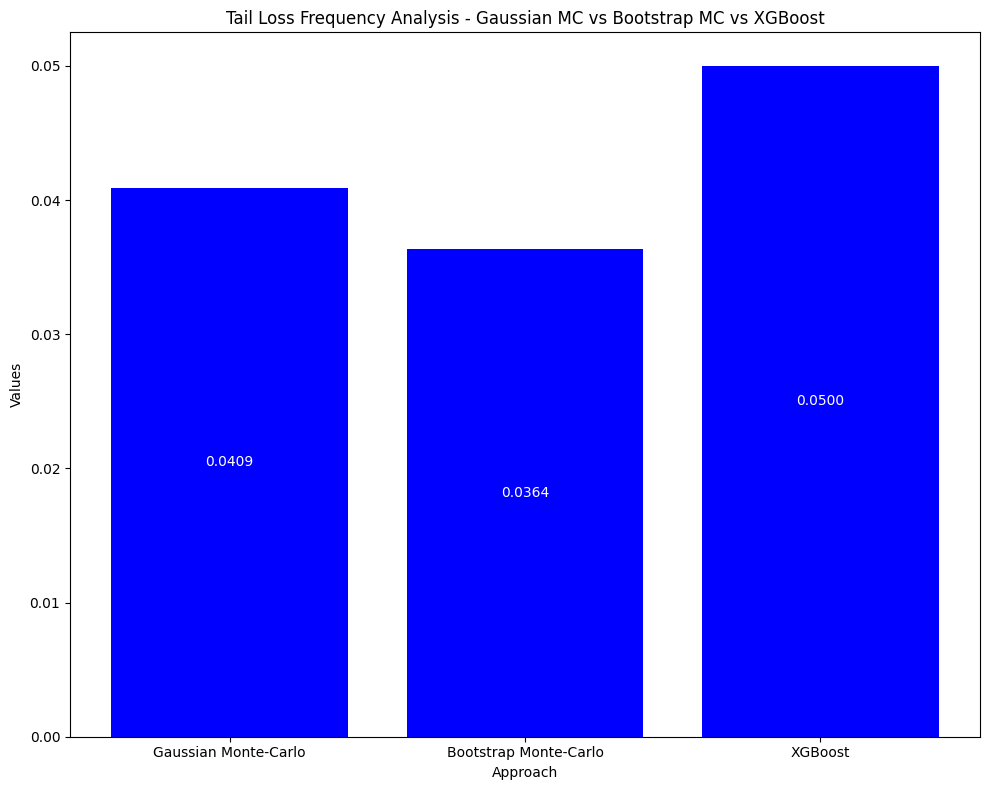

In [7]:
# Tail Loss Frequency Implementation
tlf_df = master_returns_df.copy()

# Step 1: Calculating rolling 36 month 5th percentile
tlf_df['rol_gauss_0.05_36M'] = (
    tlf_df['monthly_simple_returns_gauss_mc']
    .shift(1)
    .rolling(36)
    .quantile(0.05, interpolation='lower')
)
tlf_df['rol_boot_0.05_36M'] = (
    tlf_df['monthly_simple_returns_boot_mc']
    .shift(1)
    .rolling(36)
    .quantile(0.05, interpolation='lower')
)
tlf_df['rol_xgb_0.05_36M'] = (
    tlf_df['monthly_simple_returns_xgb']
    .shift(1)
    .rolling(36)
    .quantile(0.05, interpolation='lower')
)
tlf_df = tlf_df.dropna(how='any')

# Step 2: Identifying count of months with returns <= rolling 5th percentile (tail events) and period of evaluation
count_gauss_tail_event = (
    tlf_df['monthly_simple_returns_gauss_mc'] <= tlf_df['rol_gauss_0.05_36M']
).astype(int).sum()
count_boot_tail_event = (
    tlf_df['monthly_simple_returns_boot_mc'] <= tlf_df['rol_boot_0.05_36M']
).astype(int).sum()
count_xgb_tail_event = (
    tlf_df['monthly_simple_returns_xgb'] <= tlf_df['rol_xgb_0.05_36M']
).astype(int).sum()
months_evaluated = tlf_df['rol_gauss_0.05_36M'].count()

# Step 3: Calculating TLF
gauss_tlf = count_gauss_tail_event / months_evaluated
boot_tlf = count_boot_tail_event / months_evaluated
xgb_tlf = count_xgb_tail_event / months_evaluated

# Step 4: Plotting the analysis
y_data_tlf = [gauss_tlf, boot_tlf, xgb_tlf]
fig_tlf, ax_tlf = plt.subplots(figsize=(10, 8), dpi=100)
bars_tlf = plt.bar(x_data, y_data_tlf, color='blue')
ax_tlf.bar_label(bars_tlf, fmt='%.4f', label_type = 'center', color='white')
ax_tlf.set_title('Tail Loss Frequency Analysis - Gaussian MC vs Bootstrap MC vs XGBoost')
ax_tlf.set_xlabel('Approach')
ax_tlf.set_ylabel('Values')
plt.tight_layout()
plt.show()

**Analysis Conclusion - Tail Loss Frequency**

Tail Loss Frequency (TLF) measures how often the portfolio experiences extreme downside outcomes, defined here as monthly returns falling at or below a rolling 36-month empirical 5th percentile threshold. Unlike magnitude-based tail metrics, TLF focuses on the recurrence of tail events, providing insight into how frequently each portfolio construction approach exposes capital to severe downside risk relative to recent historical conditions.

The observed TLF results across the three approaches are as follows:
1. **Bootstrap Monte-Carlo records the lowest tail loss frequency**, with tail events occurring in 3.6% of evaluated months (8 out of 220).
2. **Gaussian Monte-Carlo follows closely**, with a TLF of 4.1% (9 tail months).
3. **XGBoost exhibits the highest tail loss frequency** at 5.0% (11 tail months), closely aligned with the nominal tail probability implied by the 5th percentile threshold.

These results indicate that the Bootstrap Monte-Carlo approach is the most effective at limiting repeated exposure to extreme downside outcomes, while XGBoost allows tail events to occur more frequently over the out-of-sample period.

From a portfolio construction perspective, this finding has direct economic relevance. Frequent tail losses tend to depress cumulative performance and increase volatility, both of which negatively impact risk-adjusted return metrics such as the Sharpe ratio. The lower TLF observed under Bootstrap Monte-Carlo is therefore consistent with its superior Sharpe performance in this study, as fewer extreme loss episodes reduce drawdowns and stabilize return distributions over time. Conversely, XGBoost’s higher tail loss frequency helps explain its relatively weaker Sharpe ratio, as more frequent tail breaches introduce additional downside volatility that is not sufficiently offset by higher returns.

Importantly, these results do not imply that XGBoost fails to identify risk. Prior regime-controlled volatility assessments indicate that XGBoost is more responsive to changes in market conditions. However, this responsiveness translates into greater willingness to re-enter risk, which increases the frequency of tail exposures at the portfolio level. In contrast, Bootstrap Monte-Carlo embeds a more conservative, distribution-aware allocation mechanism that prioritizes tail avoidance, even at the cost of slower re-risking.

In the context of this study’s objective—risk-adjusted portfolio construction with a stronger emphasis on downside risk control—the TLF results support the conclusion that Bootstrap Monte-Carlo provides the most robust balance between risk containment and return generation. By minimizing the recurrence of extreme losses, it creates a return profile that is both more stable and more efficient on a risk-adjusted basis, making it the preferred approach for risk-aware portfolio construction within the scope of this analysis.

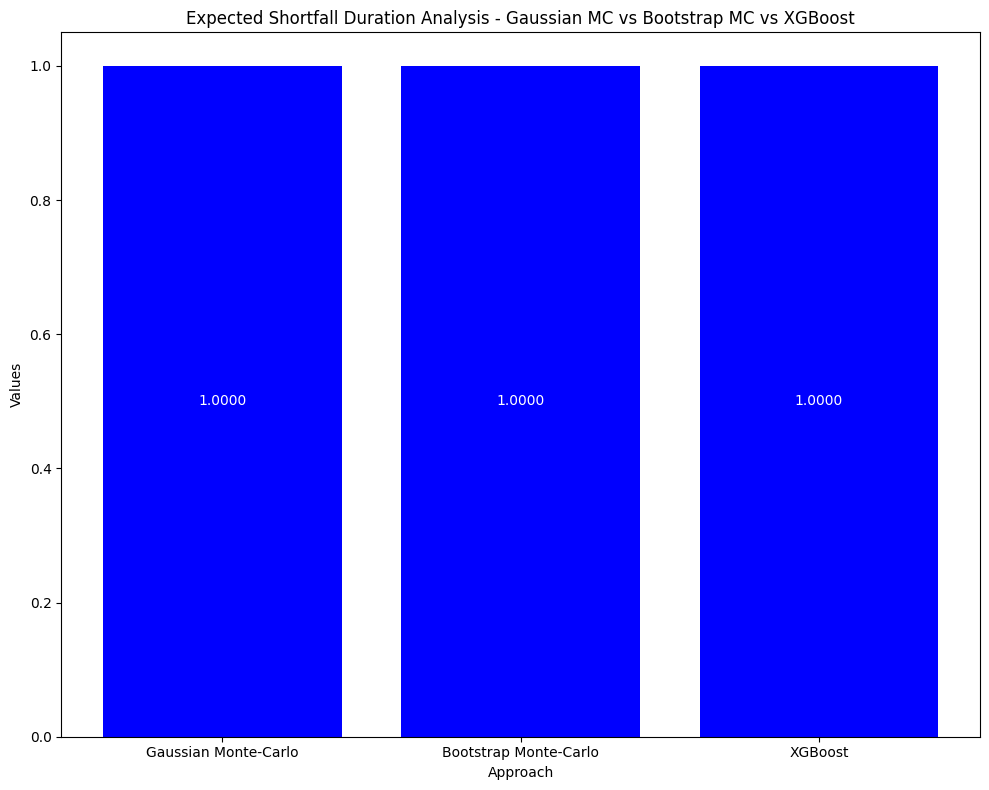

In [8]:
# Expected Shortfall Duration
esd_df = master_returns_df[['monthly_simple_returns_boot_mc', 'monthly_simple_returns_gauss_mc', 'monthly_simple_returns_xgb']].copy()
days_per_month = 30
gauss_episodes_counter = []
boot_episodes_counter = []
xgb_episodes_counter = []
gauss_N_list = []
boot_N_list = []
xgb_N_list = []

# Step 1: Generating rolling 36 month 5th percentile
esd_df['rol_gauss_0.05_36M'] = esd_df['monthly_simple_returns_gauss_mc'].rolling(36).quantile(0.05)
esd_df['rol_boot_0.05_36M'] = esd_df['monthly_simple_returns_boot_mc'].rolling(36).quantile(0.05)
esd_df['rol_xgb_0.05_36M'] = esd_df['monthly_simple_returns_xgb'].rolling(36).quantile(0.05)
esd_df = esd_df.dropna(how='any')

# Step 2: Identifying tail loss months
esd_df['gauss_tail_loss'] = (
    esd_df['monthly_simple_returns_gauss_mc'] <= esd_df['rol_gauss_0.05_36M']
).astype(int)
esd_df['boot_tail_loss'] = (
    esd_df['monthly_simple_returns_boot_mc'] <= esd_df['rol_boot_0.05_36M']
).astype(int)
esd_df['xgb_tail_loss'] = (
    esd_df['monthly_simple_returns_xgb'] <= esd_df['rol_xgb_0.05_36M']
).astype(int)

# Step 3: Calculating ESD for Gaussian MC
gauss_d_df = esd_df['gauss_tail_loss'][
    esd_df['gauss_tail_loss'] == 1
]
gauss_d_df = gauss_d_df.reset_index()
gauss_d_df['next_rebalance_date'] = pd.to_datetime(gauss_d_df['next_rebalance_date'])
gauss_d_df['days_delta'] = (pd.to_datetime(gauss_d_df['next_rebalance_date']) - pd.to_datetime(gauss_d_df['next_rebalance_date'].shift(1))).dt.days
for i in range(len(gauss_d_df)):
    if (gauss_d_df['days_delta'].iloc[i] <= days_per_month):
        gauss_episodes_counter.append(2)
    else:
        gauss_episodes_counter.append(0)

for i in range(len(gauss_episodes_counter)):
    if gauss_episodes_counter[i - 1] >= 0 and gauss_episodes_counter[i] == 2:
        gauss_N_list.append(2)
    else:
        gauss_N_list.append(1)

gauss_sequence = gauss_N_list.count(2)
gauss_N = sum(gauss_N_list) - sum(gauss_episodes_counter)
gauss_d = len(gauss_episodes_counter)
gauss_ESD = gauss_d / gauss_N

# Step 4: Calculating ESD for Bootstrap MC
boot_d_df = esd_df['boot_tail_loss'][
    esd_df['boot_tail_loss'] == 1
]
boot_d_df = boot_d_df.reset_index()
boot_d_df['next_rebalance_date'] = pd.to_datetime(boot_d_df['next_rebalance_date'])
boot_d_df['days_delta'] = (pd.to_datetime(boot_d_df['next_rebalance_date']) - pd.to_datetime(boot_d_df['next_rebalance_date'].shift(1))).dt.days
for i in range(len(boot_d_df)):
    if (boot_d_df['days_delta'].iloc[i] <= days_per_month):
        boot_episodes_counter.append(2)
    else:
        boot_episodes_counter.append(0)

for i in range(len(boot_episodes_counter)):
    if boot_episodes_counter[i - 1] >= 0 and boot_episodes_counter[i] == 2:
        boot_N_list.append(2)
    else:
        boot_N_list.append(1)

boot_sequence = boot_N_list.count(2)
boot_N = sum(boot_N_list) - sum(boot_episodes_counter)
boot_d = len(boot_episodes_counter)
boot_ESD = boot_d / boot_N

# Step 5: Calculating ESD for XGBoost
xgb_d_df = esd_df['xgb_tail_loss'][
    esd_df['xgb_tail_loss'] == 1
]
xgb_d_df = xgb_d_df.reset_index()
xgb_d_df['next_rebalance_date'] = pd.to_datetime(xgb_d_df['next_rebalance_date'])
xgb_d_df['days_delta'] = (pd.to_datetime(xgb_d_df['next_rebalance_date']) - pd.to_datetime(xgb_d_df['next_rebalance_date'].shift(1))).dt.days
for i in range(len(xgb_d_df)):
    if (xgb_d_df['days_delta'].iloc[i] <= days_per_month):
        xgb_episodes_counter.append(2)
    else:
        xgb_episodes_counter.append(0)

for i in range(len(xgb_episodes_counter)):
    if xgb_episodes_counter[i - 1] >= 0 and xgb_episodes_counter[i] == 2:
        xgb_N_list.append(2)
    else:
        xgb_N_list.append(1)

xgb_sequence = xgb_N_list.count(2)
xgb_N = sum(xgb_N_list) - sum(xgb_episodes_counter)
xgb_d = len(xgb_episodes_counter)
xgb_ESD = xgb_d / xgb_N

# Step 6: Plotting Results
y_data_esd = [gauss_ESD, boot_ESD, xgb_ESD]
fig_esd, ax_esd = plt.subplots(figsize=(10, 8), dpi = 100)
bars_esd = plt.bar(x_data, y_data_esd, color='blue')
ax_esd.bar_label(bars_esd, fmt='%.4f', label_type = 'center', color='white')
ax_esd.set_title('Expected Shortfall Duration Analysis - Gaussian MC vs Bootstrap MC vs XGBoost')
ax_esd.set_xlabel('Approach')
ax_esd.set_ylabel('Values')
plt.tight_layout()
plt.show()

**Analysis Conclusion - Expected Shortfall Duration**

Expected Shortfall Duration (ESD) measures the persistence of tail losses once they occur. Specifically, it captures the average length (in months) of consecutive tail-loss episodes, conditional on a breach of the rolling 36-month empirical 5th percentile threshold. While Tail Loss Frequency (TLF) focuses on how often extreme downside events occur, ESD provides complementary insight into how long the portfolio remains in a stressed tail state before recovering above the threshold.

The results (across all three approaches) indicate that, across all three approaches, tail losses manifest as isolated monthly events rather than persistent multi-month drawdown episodes. In other words, although tail losses do occur, none of the models exhibit meaningful clustering of extreme downside outcomes over consecutive months within the out-of-sample period.

From a risk management perspective, this is an important finding. Persistent tail episodes—where losses remain in the extreme tail for multiple consecutive months—are typically associated with prolonged capital impairment, liquidity stress, and elevated investor drawdown risk. An ESD of 1.0 suggests that, once a tail loss is realized, the portfolio recovers above the tail threshold in the following month, limiting the duration of stress exposure. This behavior is consistent with effective rebalancing and risk-reset mechanisms embedded within each approach.

The uniformity of ESD across models also implies that differences in downside risk across approaches are driven primarily by tail loss frequency and magnitude, rather than persistence. This aligns closely with the Tail Loss Frequency findings, where Bootstrap Monte-Carlo demonstrated fewer tail events overall, and XGBoost exhibited more frequent tail breaches. However, once a tail event occurs, none of the approaches display a tendency to remain trapped in extended tail-loss regimes.

It is also important to interpret this result in the context of the rolling, adaptive nature of the tail threshold used in this study. Because the 5th percentile threshold is recalibrated over a rolling 36-month window, prolonged stress periods are partially absorbed into the reference distribution, reducing the likelihood of repeated consecutive breaches. As a result, ESD acts here as a diagnostic confirming the absence of tail clustering rather than a primary discriminator between models.

In summary, the Expected Shortfall Duration analysis suggests that all three portfolio construction approaches are effective at limiting the persistence of extreme downside risk. While Bootstrap Monte-Carlo remains superior in terms of reducing the frequency of tail losses, and XGBoost exhibits higher tail recurrence, none of the models expose the portfolio to prolonged tail-loss episodes. Consequently, model differentiation in this study arises from how often and how severely tail events occur, rather than from extended drawdown persistence—an insight that reinforces the complementary roles of TLF, ESD, and maximum drawdown metrics in a comprehensive tail-risk evaluation framework.

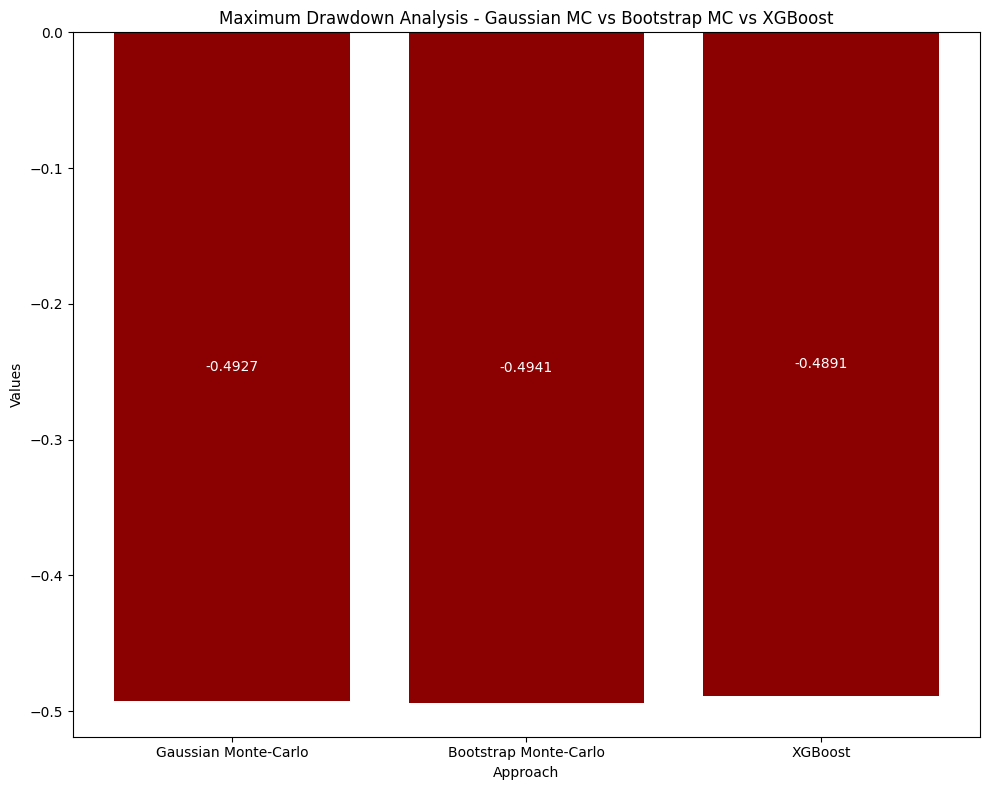

In [9]:
# Maximum Drawdown
mdd_df = master_returns_df[['monthly_simple_returns_boot_mc', 'monthly_simple_returns_gauss_mc', 'monthly_simple_returns_xgb']].copy()
V_0 = 1
V_t_gauss = [V_0]
V_t_boot = [V_0]
V_t_xgb = [V_0]

# Step 1: Calculating MDD for Gaussian MC
for i in range(len(mdd_df)):
    V_t_gauss.append(V_t_gauss[-1] * (1 + mdd_df['monthly_simple_returns_gauss_mc'].iloc[i]))

V_t_gauss.pop(0)
mdd_df['gauss_mc_cum_port_val'] = V_t_gauss
mdd_df['gauss_mc_peak'] = mdd_df['gauss_mc_cum_port_val'].cummax()
mdd_df['gauss_mc_drawdown'] = (mdd_df['gauss_mc_cum_port_val'] - mdd_df['gauss_mc_peak']) / mdd_df['gauss_mc_peak']
mdd_gauss = mdd_df['gauss_mc_drawdown'].min()

# Step 2: Calculating MDD for Bootstrap MC
for i in range(len(mdd_df)):
    V_t_boot.append(V_t_boot[-1] * (1 + mdd_df['monthly_simple_returns_boot_mc'].iloc[i]))

V_t_boot.pop(0)
mdd_df['boot_mc_cum_port_val'] = V_t_boot
mdd_df['boot_mc_peak'] = mdd_df['boot_mc_cum_port_val'].cummax()
mdd_df['boot_mc_drawdown'] = (mdd_df['boot_mc_cum_port_val'] - mdd_df['boot_mc_peak']) / mdd_df['boot_mc_peak']
mdd_boot = mdd_df['boot_mc_drawdown'].min()

# Step 3: Calculating MDD for XGBoost
for i in range(len(mdd_df)):
    V_t_xgb.append(V_t_xgb[-1] * (1 + mdd_df['monthly_simple_returns_xgb'].iloc[i]))

V_t_xgb.pop(0)
mdd_df['xgb_mc_cum_port_val'] = V_t_xgb
mdd_df['xgb_mc_peak'] = mdd_df['xgb_mc_cum_port_val'].cummax()
mdd_df['xgb_mc_drawdown'] = (mdd_df['xgb_mc_cum_port_val'] - mdd_df['xgb_mc_peak']) / mdd_df['xgb_mc_peak']
mdd_xgb = mdd_df['xgb_mc_drawdown'].min()

# Plotting results
y_data_mdd = [mdd_gauss, mdd_boot, mdd_xgb]
fig_mdd, ax_mdd = plt.subplots(figsize=(10, 8), dpi = 100)
bars_mdd = plt.bar(x_data, y_data_mdd, color='darkred')
ax_mdd.bar_label(bars_mdd, fmt='%.4f', label_type = 'center', color='white')
ax_mdd.set_title('Maximum Drawdown Analysis - Gaussian MC vs Bootstrap MC vs XGBoost')
ax_mdd.set_xlabel('Approach')
ax_mdd.set_ylabel('Values')
plt.tight_layout()
plt.show()

**Analysis Conclusion - Maximum Drawdown**

Maximum Drawdown (MDD) measures the worst peak-to-trough loss experienced by the portfolio over the out-of-sample period. Unlike tail loss frequency, which focuses on how often extreme losses occur, MDD captures the maximum cumulative damage caused by adverse return sequences. As a path-dependent metric, it reflects not only the severity of individual losses but also the clustering and persistence of downside shocks over time.

The observed maximum drawdowns across the three portfolio construction approaches are as follows:
1. **XGBoost** records the lowest maximum drawdown, at approximately −48.9%.
2. **Gaussian Monte-Carlo** follows closely, with a maximum drawdown of −49.3%.
3. **Bootstrap Monte-Carlo** exhibits the deepest drawdown, at roughly −49.4%.

While the absolute differences across approaches are modest, the ranking is economically meaningful. XGBoost’s marginally lower drawdown indicates that, despite experiencing tail losses more frequently (as evidenced by its higher TLF), these losses tend to be less damaging in aggregate, preventing the portfolio from reaching as deep a cumulative trough. In contrast, Bootstrap Monte-Carlo, while effective at reducing the frequency of tail events, is more vulnerable to prolonged or clustered stress episodes, which compound over time into a slightly deeper peak-to-trough loss.

From a portfolio construction perspective, this highlights an important distinction between tail frequency control and drawdown containment. Bootstrap Monte-Carlo emphasizes distributional robustness and tail avoidance at the monthly level, but once adverse conditions persist, its slower re-risking behavior can delay recovery, allowing cumulative losses to deepen. Gaussian Monte-Carlo displays similar behavior, reflecting its reliance on fixed parametric assumptions that may under-adapt during extended stress regimes.

XGBoost’s relatively lower MDD aligns with earlier regime-sensitivity findings. Its adaptive, feature-driven allocation framework allows it to adjust exposures dynamically as conditions evolve, limiting the total depth of cumulative losses even if it re-enters risk more frequently. This suggests that XGBoost manages drawdown severity more effectively than it manages tail event recurrence, reinforcing the view that it prioritizes responsiveness over conservatism.

In the broader context of this study, the MDD results complement the tail loss frequency and expected shortfall duration analyses. Bootstrap Monte-Carlo excels at minimizing repeated tail exposures, while XGBoost performs better at limiting the maximum capital impairment once stress unfolds. Consequently, the choice between approaches depends on the investor’s primary risk objective: minimizing the occurrence of extreme losses versus constraining the worst-case cumulative drawdown. For strictly risk-aware portfolio construction with an emphasis on tail avoidance, Bootstrap Monte-Carlo remains preferable, whereas for investors more concerned with containing peak-to-trough losses and enabling faster recovery, XGBoost offers a modest advantage.

### 3. Portfolio Stability Analysis (Gaussian Monte-Carlo v/s Bootstrap Monte-Carlo v/s XGBoost)

This sub-section evaluates the stability and consistency of portfolio decisions generated by each portfolio construction approach over time. While the preceding analyses focus on return efficiency, downside protection, and drawdown behavior, the emphasis here is on the temporal robustness and implementability of the resulting asset allocations.

The objective is to assess whether observed risk-adjusted and tail-risk outcomes are achieved through stable, regime-consistent portfolio adjustments or through frequent and potentially noisy reallocation decisions that may undermine real-world applicability.

The analysis employs a single out-of-sample metric:

1. Monthly Turnover – to quantify the magnitude of portfolio reallocation between consecutive monthly rebalancing periods, capturing the stability of allocation decisions implied by each modelling framework

Monthly turnover measures the total absolute change in asset weights from one rebalancing period to the next and serves as a proxy for the consistency of the model’s risk assessment over time. Lower turnover indicates smoother and more persistent portfolio allocations, suggesting stable risk estimates and controlled responses to evolving market conditions. Conversely, higher turnover may reflect sensitivity to short-term fluctuations, estimation noise, or frequent reassessment of risk regimes.

In the context of risk-aware portfolio construction, turnover does not represent a cost-efficiency metric but rather a diagnostic of decision stability. A model that frequently reshuffles portfolio weights may still achieve favorable risk-adjusted or tail-risk outcomes, yet such performance may rely on fragile or over-reactive signals that are difficult to sustain outside a backtesting environment.

Evaluating turnover alongside risk-adjusted performance and tail-risk metrics enables a more holistic assessment of each approach, distinguishing between models that achieve risk resilience through measured structural adaptation and those that rely on frequent tactical repositioning.

Monthly turnover is computed consistently across all approaches using out-of-sample portfolio weights generated at each monthly rebalance, ensuring comparability of stability characteristics under identical evaluation conditions.

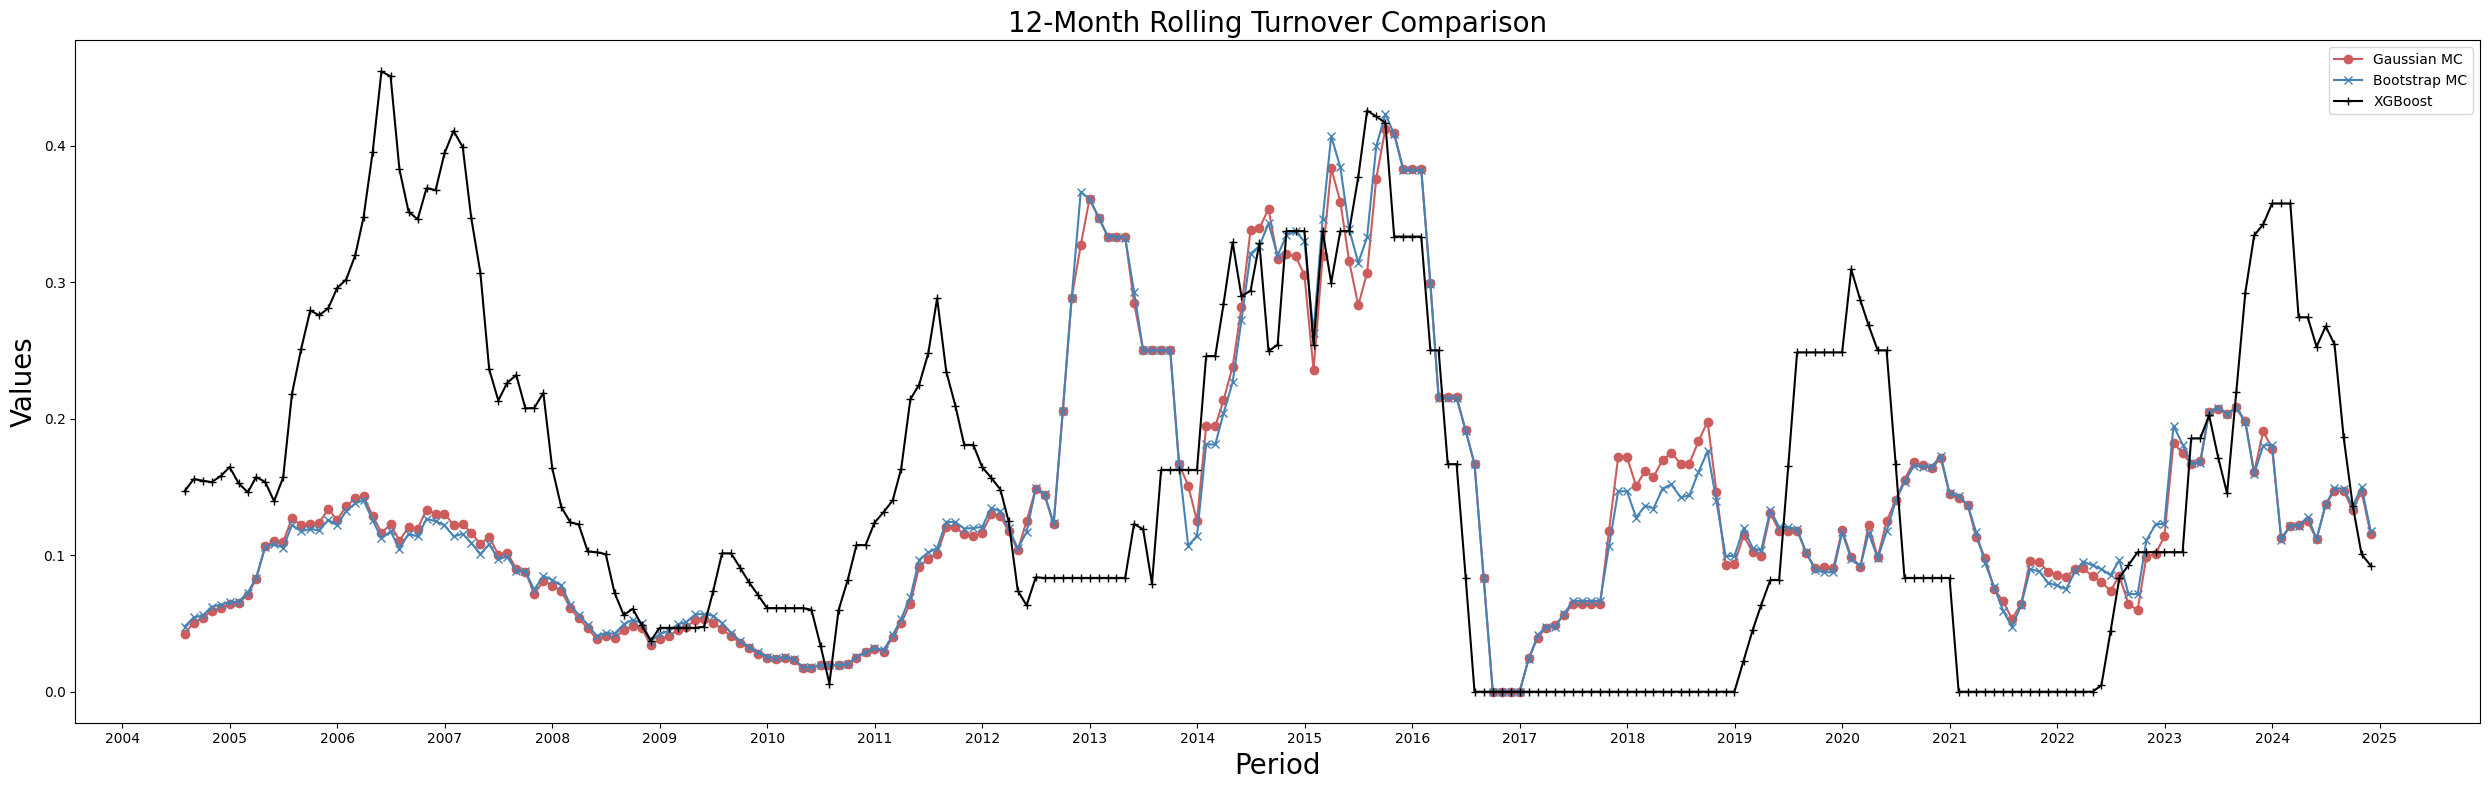

In [10]:
# Monthly turnover
mturn_df = master_weights_df.copy()

# Step 1: Calculating monthly turnover - Gaussian MC
mturn_df['gauss_mc_NIFTY50_change'] = mturn_df['weights_gauss_mc_NIFTY50_RETURNS'].diff().abs()
mturn_df['gauss_mc_NIFTYBank_change'] = mturn_df['weights_gauss_mc_NIFTYBank_RETURNS'].diff().abs()
mturn_df['gauss_mc_GOLD_FUTURES_change'] = mturn_df['weights_gauss_mc_GOLD_FUTURES_RETURNS'].diff().abs()
mturn_df['gauss_mc_turnover'] = mturn_df[['gauss_mc_NIFTY50_change', 'gauss_mc_NIFTYBank_change', 'gauss_mc_GOLD_FUTURES_change']].sum(axis=1).fillna(0)
mturn_df['gauss_mc_half_turnover'] = 0.5 * mturn_df['gauss_mc_turnover']
mturn_df['gauss_rol_turn'] = mturn_df['gauss_mc_half_turnover'].rolling(12).mean()

# Step 2: Calculating monthly turnover - Bootstrap MC
mturn_df['boot_mc_NIFTY50_change'] = mturn_df['weights_boot_mc_NIFTY50_RETURNS'].diff().abs()
mturn_df['boot_mc_NIFTYBank_change'] = mturn_df['weights_boot_mc_NIFTYBank_RETURNS'].diff().abs()
mturn_df['boot_mc_GOLD_FUTURES_change'] = mturn_df['weights_boot_mc_GOLD_FUTURES_RETURNS'].diff().abs()
mturn_df['boot_mc_turnover'] = mturn_df[['boot_mc_NIFTY50_change', 'boot_mc_NIFTYBank_change', 'boot_mc_GOLD_FUTURES_change']].sum(axis=1).fillna(0)
mturn_df['boot_mc_half_turnover'] = 0.5 * mturn_df['boot_mc_turnover']
mturn_df['boot_rol_turn'] = mturn_df['boot_mc_half_turnover'].rolling(12).mean()

# Step 3: Calculating monthly turnover - XGBoost
mturn_df['xgb_NIFTY50_change'] = mturn_df['weights_xgb_NIFTY50_RETURNS'].diff().abs()
mturn_df['xgb_NIFTYBank_change'] = mturn_df['weights_xgb_NIFTYBank_RETURNS'].diff().abs()
mturn_df['xgb_GOLD_FUTURES_change'] = mturn_df['weights_xgb_GOLD_FUTURES_RETURNS'].diff().abs()
mturn_df['xgb_turnover'] = mturn_df[['xgb_NIFTY50_change', 'xgb_NIFTYBank_change', 'xgb_GOLD_FUTURES_change']].sum(axis=1).fillna(0)
mturn_df['xgb_half_turnover'] = 0.5 * mturn_df['xgb_turnover']
mturn_df['xgb_rol_turn'] = mturn_df['xgb_half_turnover'].rolling(12).mean()

# Step 4: Synthesizing data for plots
x_data_mturn = pd.to_datetime(mturn_df.index).to_list()
y_mturn_gauss = mturn_df['gauss_rol_turn'].to_list()
y_mturn_boot = mturn_df['boot_rol_turn'].to_list()
y_mturn_xgb = mturn_df['xgb_rol_turn'].to_list()

# Step 8: Generating plots
fig_mturn, ax_mturn = plt.subplots(figsize=(25, 8), dpi=100)
plt.plot(x_data_mturn, y_mturn_gauss, color='indianred', marker='o', label='Gaussian MC')
plt.plot(x_data_mturn, y_mturn_boot, color='steelblue', marker='x', label='Bootstrap MC')
plt.plot(x_data_mturn, y_mturn_xgb, color='black', marker='+', label='XGBoost')
ax_mturn.set_title('12-Month Rolling Turnover Comparison', fontsize=20)
ax_mturn.set_xlabel('Period', fontsize=20)
ax_mturn.set_ylabel('Values', fontsize=20)
ax_mturn.legend()
ax_mturn.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_mturn.xaxis.set_major_locator(mdates.MonthLocator([12]))
plt.tight_layout()
plt.show()

**Analysis Conclusion - Monthly Turnover**

Monthly turnover evaluates the stability and consistency of portfolio allocation decisions over time by measuring the extent of rebalancing required between consecutive periods. Unlike risk-adjusted performance metrics, which focus on outcome efficiency, or tail-risk measures, which emphasize loss severity and persistence, turnover captures the behavioral and structural stability of the underlying portfolio construction process. As such, it provides insight into whether observed risk outcomes are achieved through smooth regime adaptation or frequent tactical repositioning.

To improve interpretability and focus on persistent allocation behavior rather than month-to-month noise, portfolio turnover is analyzed using a 12-month rolling average of half-turnover, allowing for clearer identification of sustained differences in allocation stability across modelling approaches.

The observed turnover dynamics across the three approaches reveal a clear and consistent ranking:
1. **XGBoost** exhibits the highest and most variable turnover across the sample, with pronounced and persistent spikes during periods of heightened market uncertainty.
2. **Bootstrap Monte-Carlo** demonstrates moderate turnover, closely tracking Gaussian Monte-Carlo but with slightly higher responsiveness during regime transitions.
3. **Gaussian Monte-Carlo** consistently displays the lowest and smoothest turnover profile, indicating the most stable allocation behavior over time.

The elevated and episodic turnover observed for XGBoost reflects its adaptive, feature-driven framework, which frequently reassesses risk conditions and reallocates capital accordingly. While this responsiveness allows XGBoost to adjust exposures rapidly as regimes evolve, it also results in sustained periods of heightened rebalancing intensity, particularly around major structural transitions. This behavior is consistent with earlier findings showing higher tail-loss frequency but improved drawdown containment, suggesting that XGBoost prioritizes continuous adjustment over allocation persistence.

In contrast, both Monte-Carlo–based approaches exhibit substantially smoother turnover profiles, indicating greater stability in portfolio construction decisions. Gaussian Monte-Carlo, in particular, benefits from fixed parametric assumptions that dampen allocation volatility, resulting in gradual and measured rebalancing. Bootstrap Monte-Carlo, while sharing this overall stability, displays marginally higher turnover during stressed periods, reflecting its sensitivity to empirical distributional shifts without fully abandoning allocation persistence.

From a portfolio construction perspective, these results highlight an important trade-off between adaptability and stability. XGBoost’s higher turnover underscores its strength in responding quickly to evolving risk environments but raises concerns around potential over-reactivity and reduced implementability in real-world settings. The Monte-Carlo approaches, especially Gaussian Monte-Carlo, achieve risk resilience through more stable and predictable allocation paths, aligning closely with objectives centered on robustness and behavioral consistency.

In the broader context of this study, the turnover analysis complements the risk-adjusted performance and tail-risk findings. Bootstrap Monte-Carlo emerges as a balanced approach, offering improved tail control relative to Gaussian Monte-Carlo while maintaining moderate allocation stability. XGBoost, meanwhile, demonstrates superior adaptability at the cost of higher decision instability. Consequently, for risk-aware portfolio construction where stability and robustness are prioritized alongside tail-risk mitigation, the Monte-Carlo frameworks—particularly Bootstrap Monte-Carlo—remain more suitable, whereas XGBoost may be preferable in settings where rapid regime adaptation is valued despite higher rebalancing intensity.

## **Section 3: Conclusion**

### 1. Gaussian Monte-Carlo: strengths, weaknesses, and role in this study

**Strengths**

- **Stability and smooth allocation behavior**  
  Gaussian Monte-Carlo produces the smoothest allocation paths and the lowest portfolio turnover across the evaluation horizon. This reflects high allocation persistence and strong implementation stability, attributes that are valuable from a governance and execution perspective.

- **Predictable and interpretable risk dynamics**  
  The model responds to changes in market conditions in a gradual and averaged manner, making its behavior easy to interpret and suitable as a baseline risk framework.

- **Competitive regime-conditioned performance**  
  When evaluated within explicitly defined calm and stress regimes, Gaussian Monte-Carlo exhibits performance broadly comparable to Bootstrap Monte-Carlo, reinforcing its value as a stable benchmark.

**Weaknesses**

- **Distributional misspecification risk**  
  Given the empirically observed non-Gaussian nature of returns, the Gaussian assumption exposes the model to systematic understatement of tail risk, particularly during extreme market conditions.

- **Delayed recognition of regime shifts**  
  The same smoothing properties that improve stability also limit responsiveness around regime transitions, where risk often changes abruptly rather than continuously.

**Summary**  
Gaussian Monte-Carlo serves as a robust and interpretable benchmark with strong stability properties, but its reliance on restrictive distributional assumptions limits its suitability as the primary risk model when empirical data rejects normality.

### 2. Bootstrap Monte-Carlo: strengths, weaknesses, and alignment with risk-adjusted portfolio construction

**Strengths**

- **Superior tail-risk control in frequency terms**  
  Bootstrap Monte-Carlo exhibits the lowest tail loss frequency among the three approaches, indicating fewer realized breaches of extreme downside thresholds. This directly supports improved risk-adjusted performance by reducing repeated tail events that mechanically degrade Sharpe ratios.

- **Best balance of Sharpe and CVaR across regimes**  
  Across calm and stress regimes, Bootstrap Monte-Carlo delivers a marginally higher Sharpe ratio than Gaussian Monte-Carlo without worsening Conditional Value-at-Risk. This indicates improved efficiency without compensating through additional downside exposure.

- **Empirical distribution fidelity with controlled adaptiveness**  
  The bootstrap framework captures fat tails and skewness present in the data while maintaining smoother allocation dynamics than machine-learning-based approaches. This places it in an effective middle ground between realism and implementability.

- **Consistent performance across diagnostics**  
  The model demonstrates coherent behavior across volatility analysis, regime-conditioned risk-adjusted metrics, tail-risk diagnostics, and turnover assessments, reinforcing its robustness as a portfolio construction engine.

**Weaknesses**

- **Slightly deeper maximum drawdown**  
  Bootstrap Monte-Carlo exhibits a marginally larger maximum drawdown than the other approaches. While the difference is modest, it reflects exposure to path-dependent drawdown accumulation during prolonged stress periods.

- **Lack of explicit regime classification**  
  The model adapts implicitly through rolling estimation rather than explicitly identifying or classifying market regimes.

**Summary**  
Bootstrap Monte-Carlo offers the most defensible balance between statistical realism, downside protection, and portfolio stability, making it the most appropriate primary approach for risk-adjusted portfolio construction in this study.

### 3. XGBoost: strengths, weaknesses, and its role as a regime-aware risk engine

**Strengths**

- **Strong regime sensitivity and risk recognition**  
  XGBoost responds sharply and discontinuously around major market stress events, effectively capturing regime transitions and shifts in risk dynamics.

- **High modelling flexibility and control**  
  The framework allows explicit control over feature engineering, hyperparameters, and functional form, enabling targeted modelling of nonlinear interactions, volatility clustering, and regime persistence.

- **Improved drawdown containment**  
  XGBoost achieves the shallowest maximum drawdown among the three approaches, indicating effective capital preservation during severe market declines.

**Weaknesses**

- **Inferior risk-adjusted performance metrics**  
  Despite its regime awareness, XGBoost delivers materially lower Sharpe ratios and more severe CVaR outcomes across both calm and stress regimes, indicating that risk recognition does not automatically translate into improved risk-adjusted returns.

- **Highest tail loss frequency**  
  The model experiences tail events more frequently, consistent with a more active and reactive risk posture.

- **Elevated turnover and implementation costs**  
  XGBoost produces the highest and most volatile turnover profile, particularly during uncertain market phases, raising concerns around transaction costs and operational robustness.

**Summary**  
XGBoost functions best as a regime identification and risk signalling framework rather than as a standalone portfolio construction engine within this setup.

### 4. Final synthesis and recommendation

Across volatility diagnostics, regime-conditioned risk-adjusted performance, tail-risk behavior, drawdown containment, and portfolio stability, Bootstrap Monte-Carlo emerges as the approach most closely aligned with the objective of risk-adjusted portfolio construction. Its empirical distribution consistency, lowest tail loss frequency, balanced Sharpe–CVaR trade-off, and moderate turnover collectively position it as the most robust primary risk engine. Gaussian Monte-Carlo remains a valuable benchmark characterized by stability and interpretability but is constrained by distributional assumptions. XGBoost, while offering superior regime sensitivity and drawdown containment, incurs meaningful costs in Sharpe, CVaR, tail frequency, and turnover, making it better suited as a complementary regime-aware overlay rather than the core portfolio construction mechanism.


**END OF DOCUMENT**